## Predictin with SMOTE and Random Forest Classification

Training the model with zone_2, zone_5 and zone_9.

Memory usage: 274.86 MB


INFO:__main__:Spatial indices already exist for zone_1
INFO:__main__:Spatial indices already exist for zone_10
INFO:__main__:Spatial indices already exist for zone_2
INFO:__main__:Spatial indices already exist for zone_3
INFO:__main__:Spatial indices already exist for zone_4
INFO:__main__:Spatial indices already exist for zone_5
INFO:__main__:Spatial indices already exist for zone_6
INFO:__main__:Spatial indices already exist for zone_7
INFO:__main__:Spatial indices already exist for zone_8
INFO:__main__:Spatial indices already exist for zone_9
INFO:__main__:Processing 3 selected zones: ['zone_2', 'zone_5', 'zone_9']
INFO:__main__:Loading zone data in parallel...
INFO:__main__:Combined data shape: (75000000, 12)


Memory usage: 5546.09 MB


INFO:__main__:Training Random Forest models in parallel...
INFO:__main__:Processing and visualizing zones...
INFO:__main__:Processing zone_2
INFO:__main__:Processing zone: zone_2
INFO:__main__:Loaded data from zone_2, shape: (25000000, 12)
INFO:__main__:Found 7501160 samples for zone zone_2
INFO:__main__:Making predictions for zone_2 using pre-trained models...


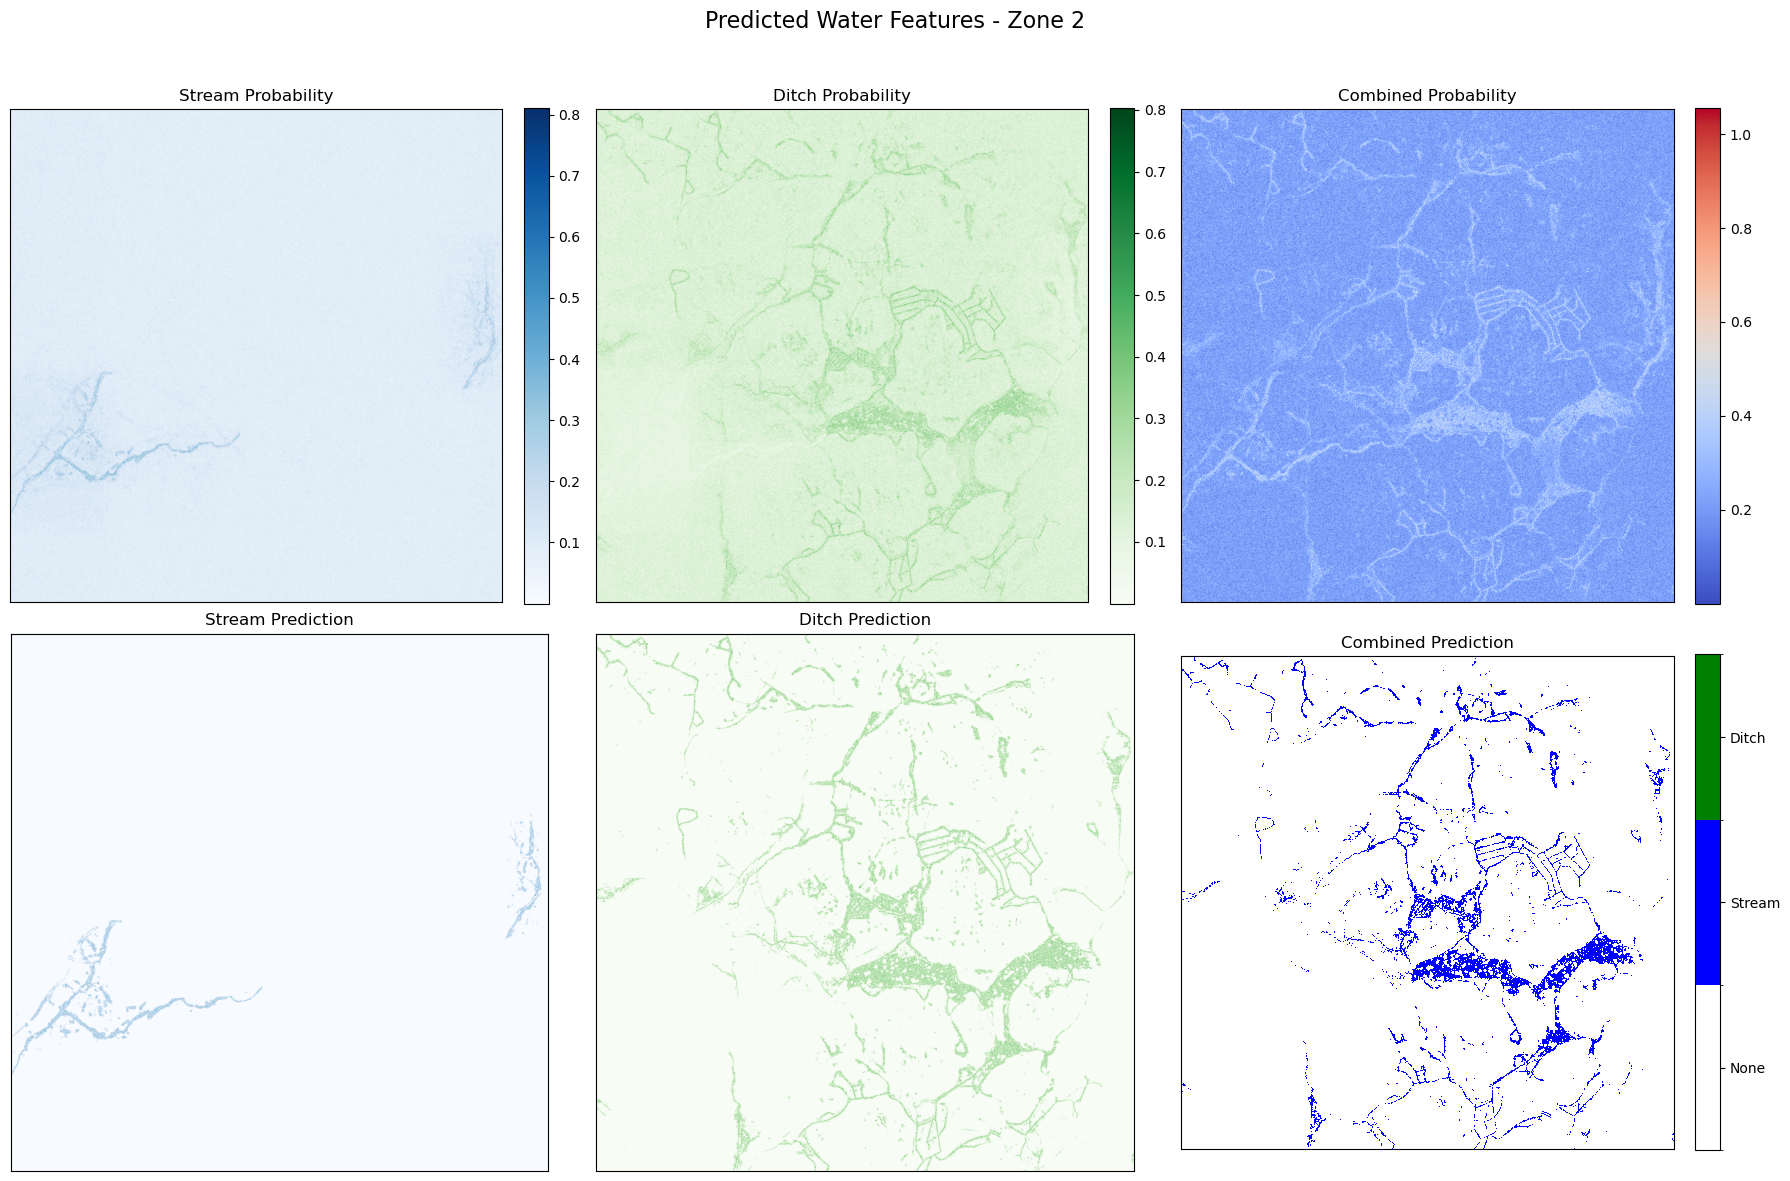

Saving figure to: ../02_Results/comparison_with_ground_truth_-_zone_2.png
Figure saved successfully


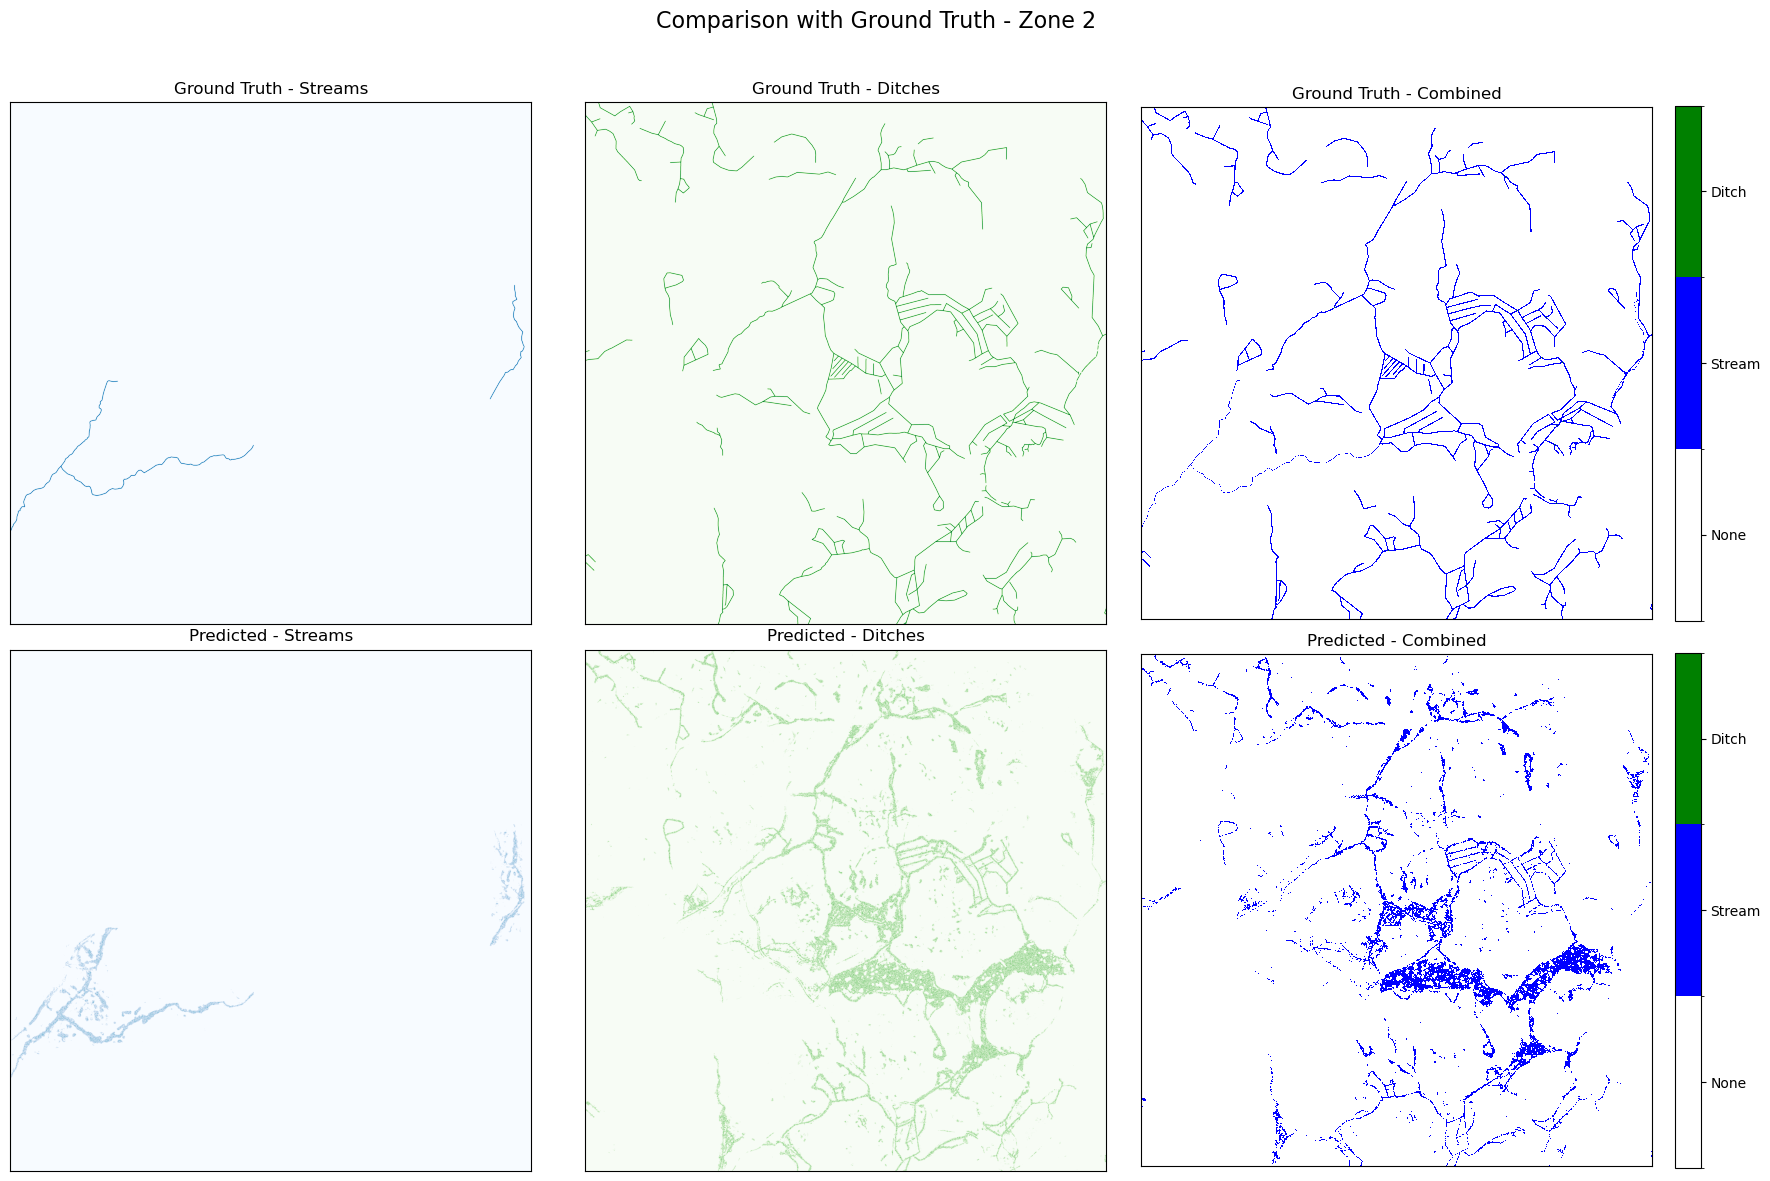

INFO:__main__:Saved visualizations for zone zone_2 to ../02_Results
INFO:__main__:Saving predictions for zone_2 to Zarr file
INFO:__main__:Saved data for zone_2
INFO:__main__:Processing zone_5
INFO:__main__:Processing zone: zone_5
INFO:__main__:Loaded data from zone_5, shape: (25000000, 12)
INFO:__main__:Found 7499218 samples for zone zone_5
INFO:__main__:Making predictions for zone_5 using pre-trained models...


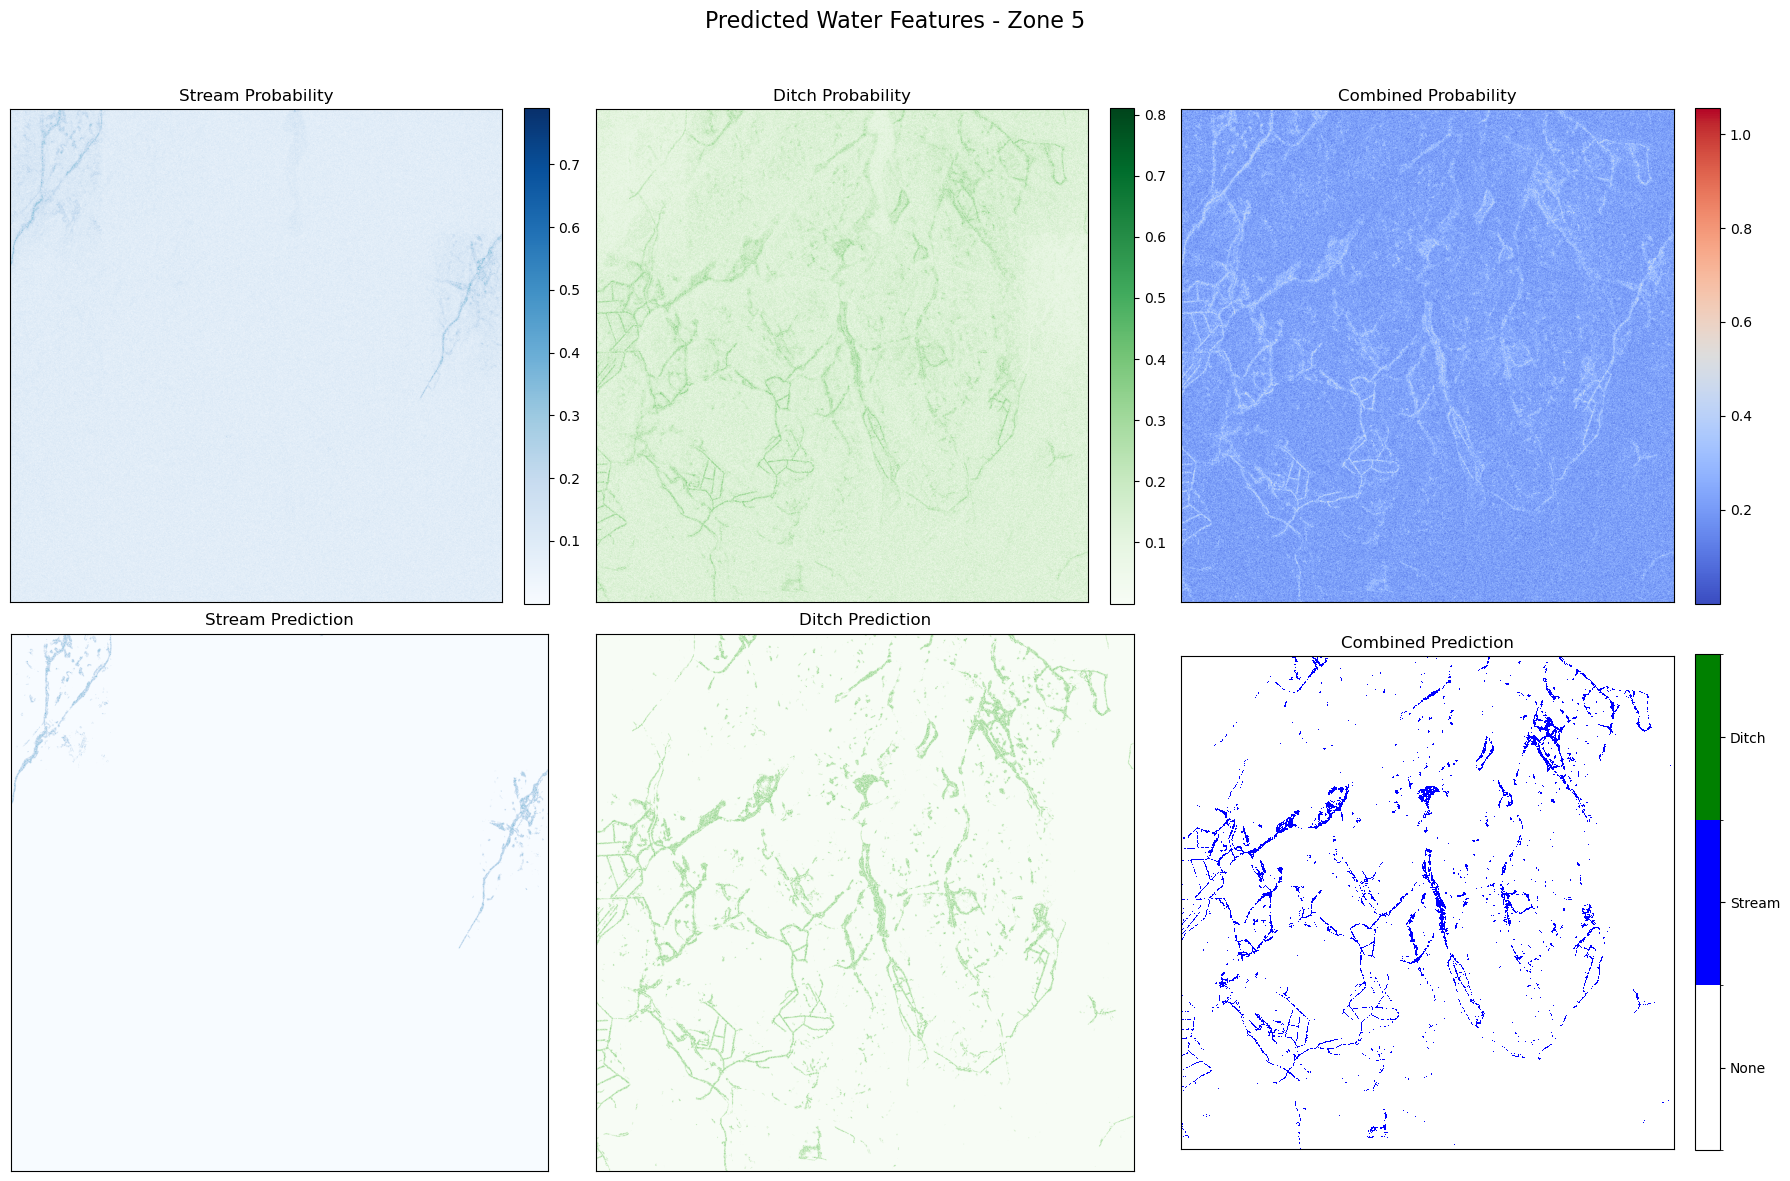

Saving figure to: ../02_Results/comparison_with_ground_truth_-_zone_5.png
Figure saved successfully


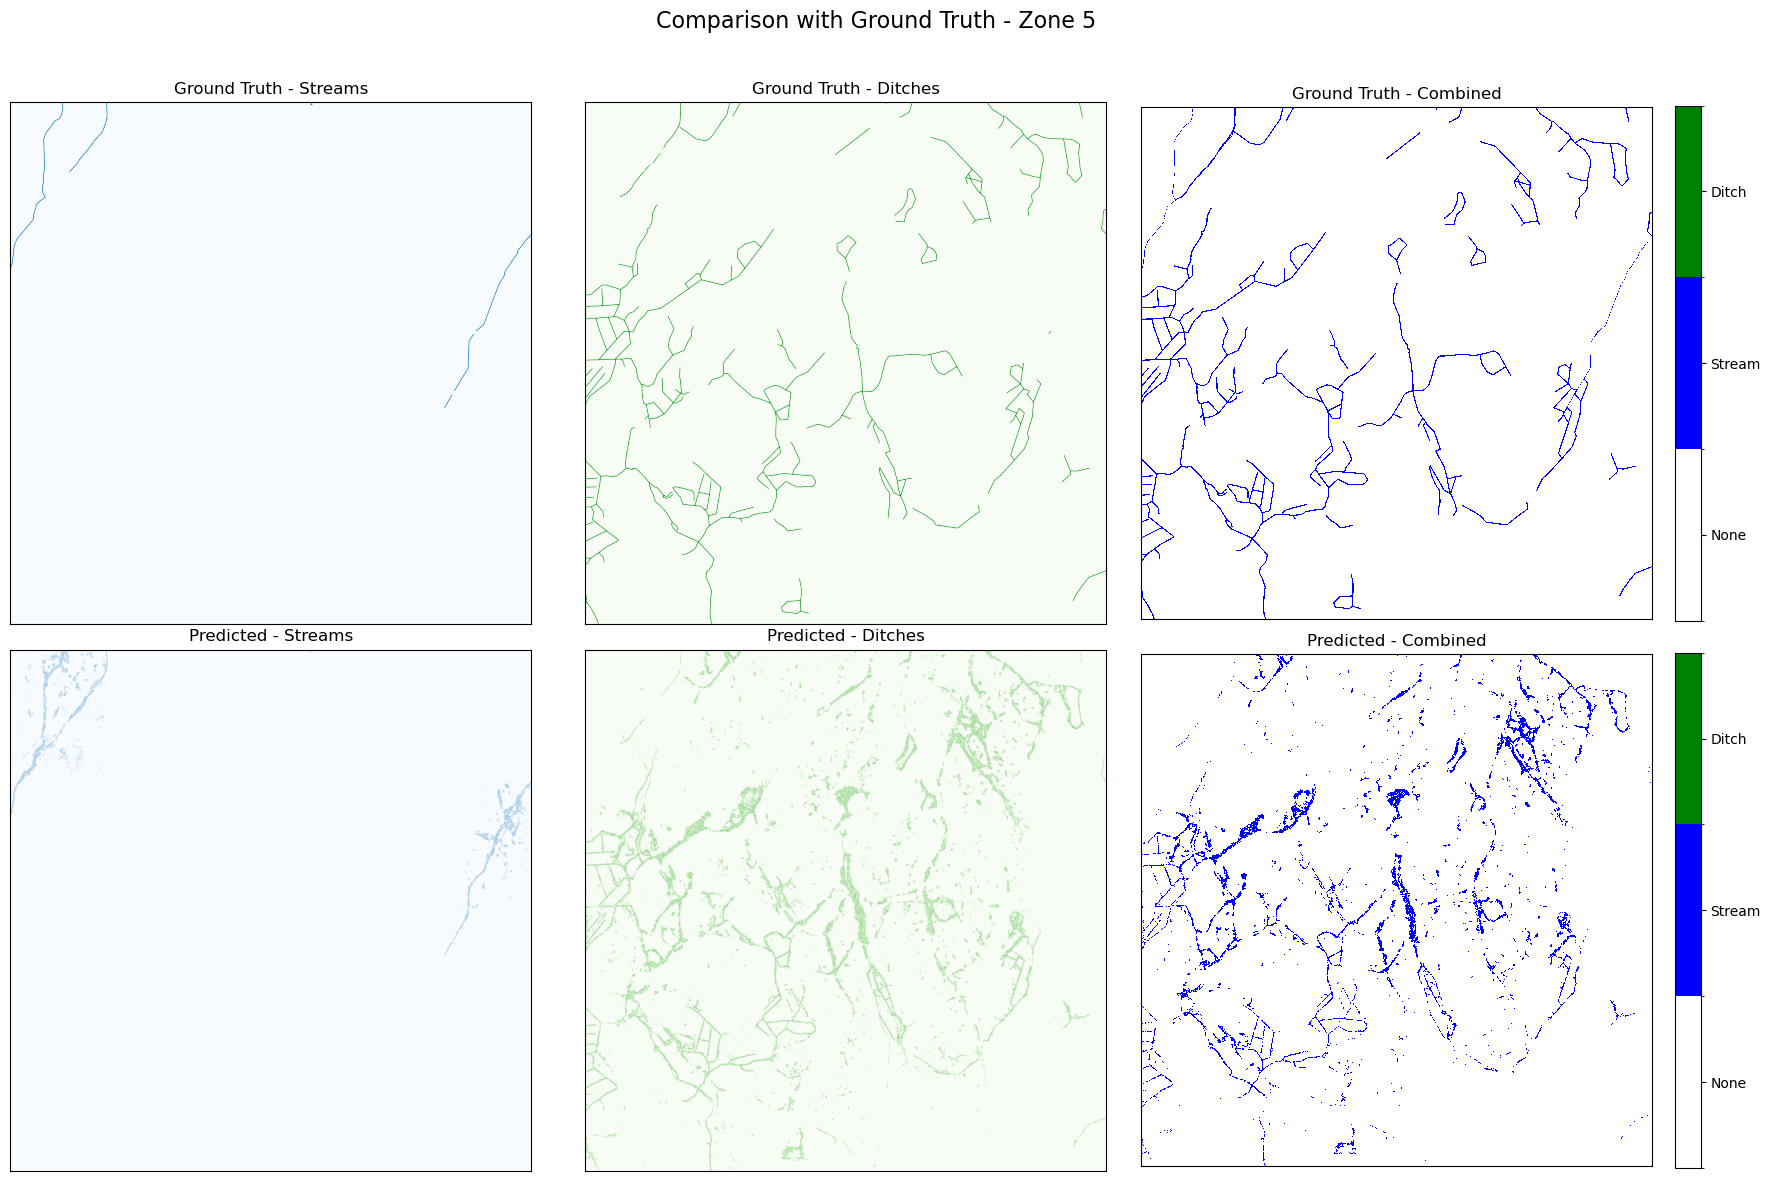

INFO:__main__:Saved visualizations for zone zone_5 to ../02_Results
INFO:__main__:Saving predictions for zone_5 to Zarr file
INFO:__main__:Saved data for zone_5
INFO:__main__:Processing zone_9
INFO:__main__:Processing zone: zone_9
INFO:__main__:Loaded data from zone_9, shape: (25000000, 12)
INFO:__main__:Found 7499622 samples for zone zone_9
INFO:__main__:Making predictions for zone_9 using pre-trained models...


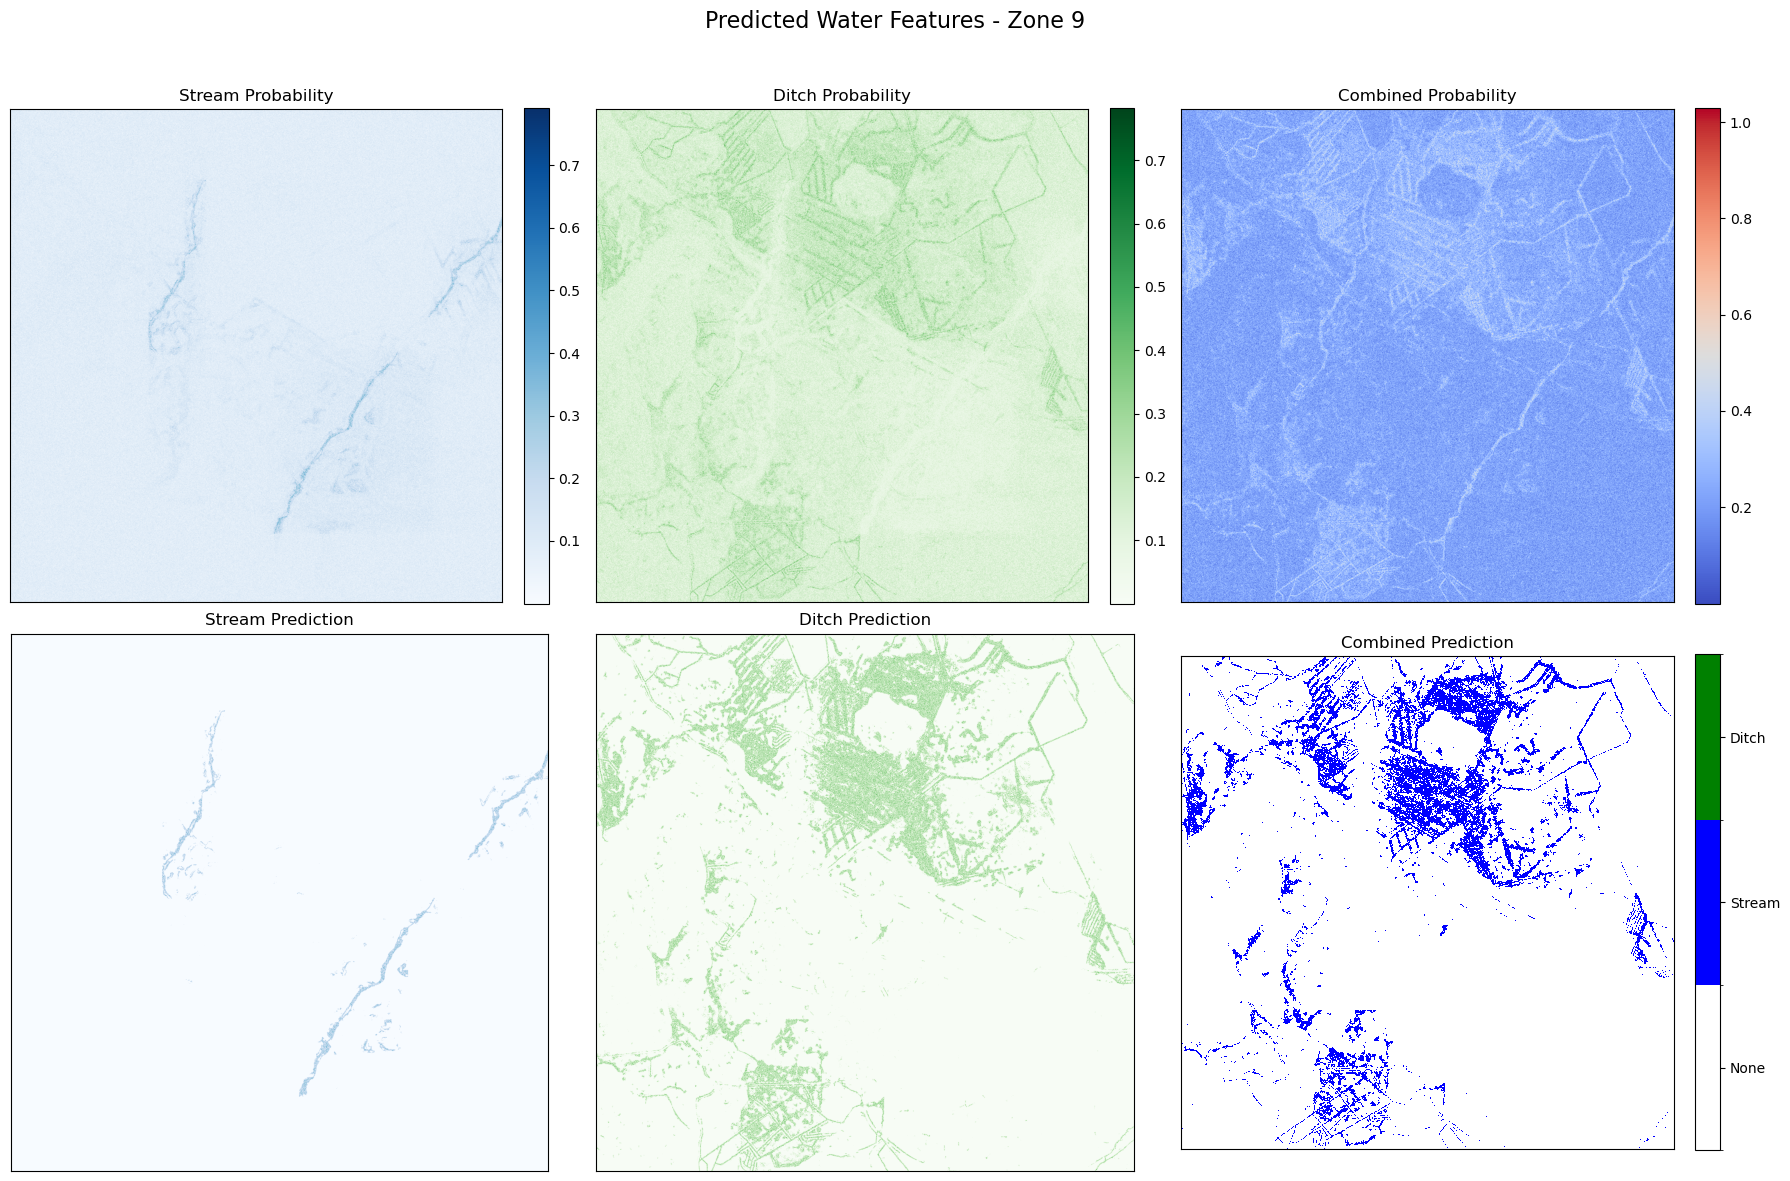

Saving figure to: ../02_Results/comparison_with_ground_truth_-_zone_9.png
Figure saved successfully


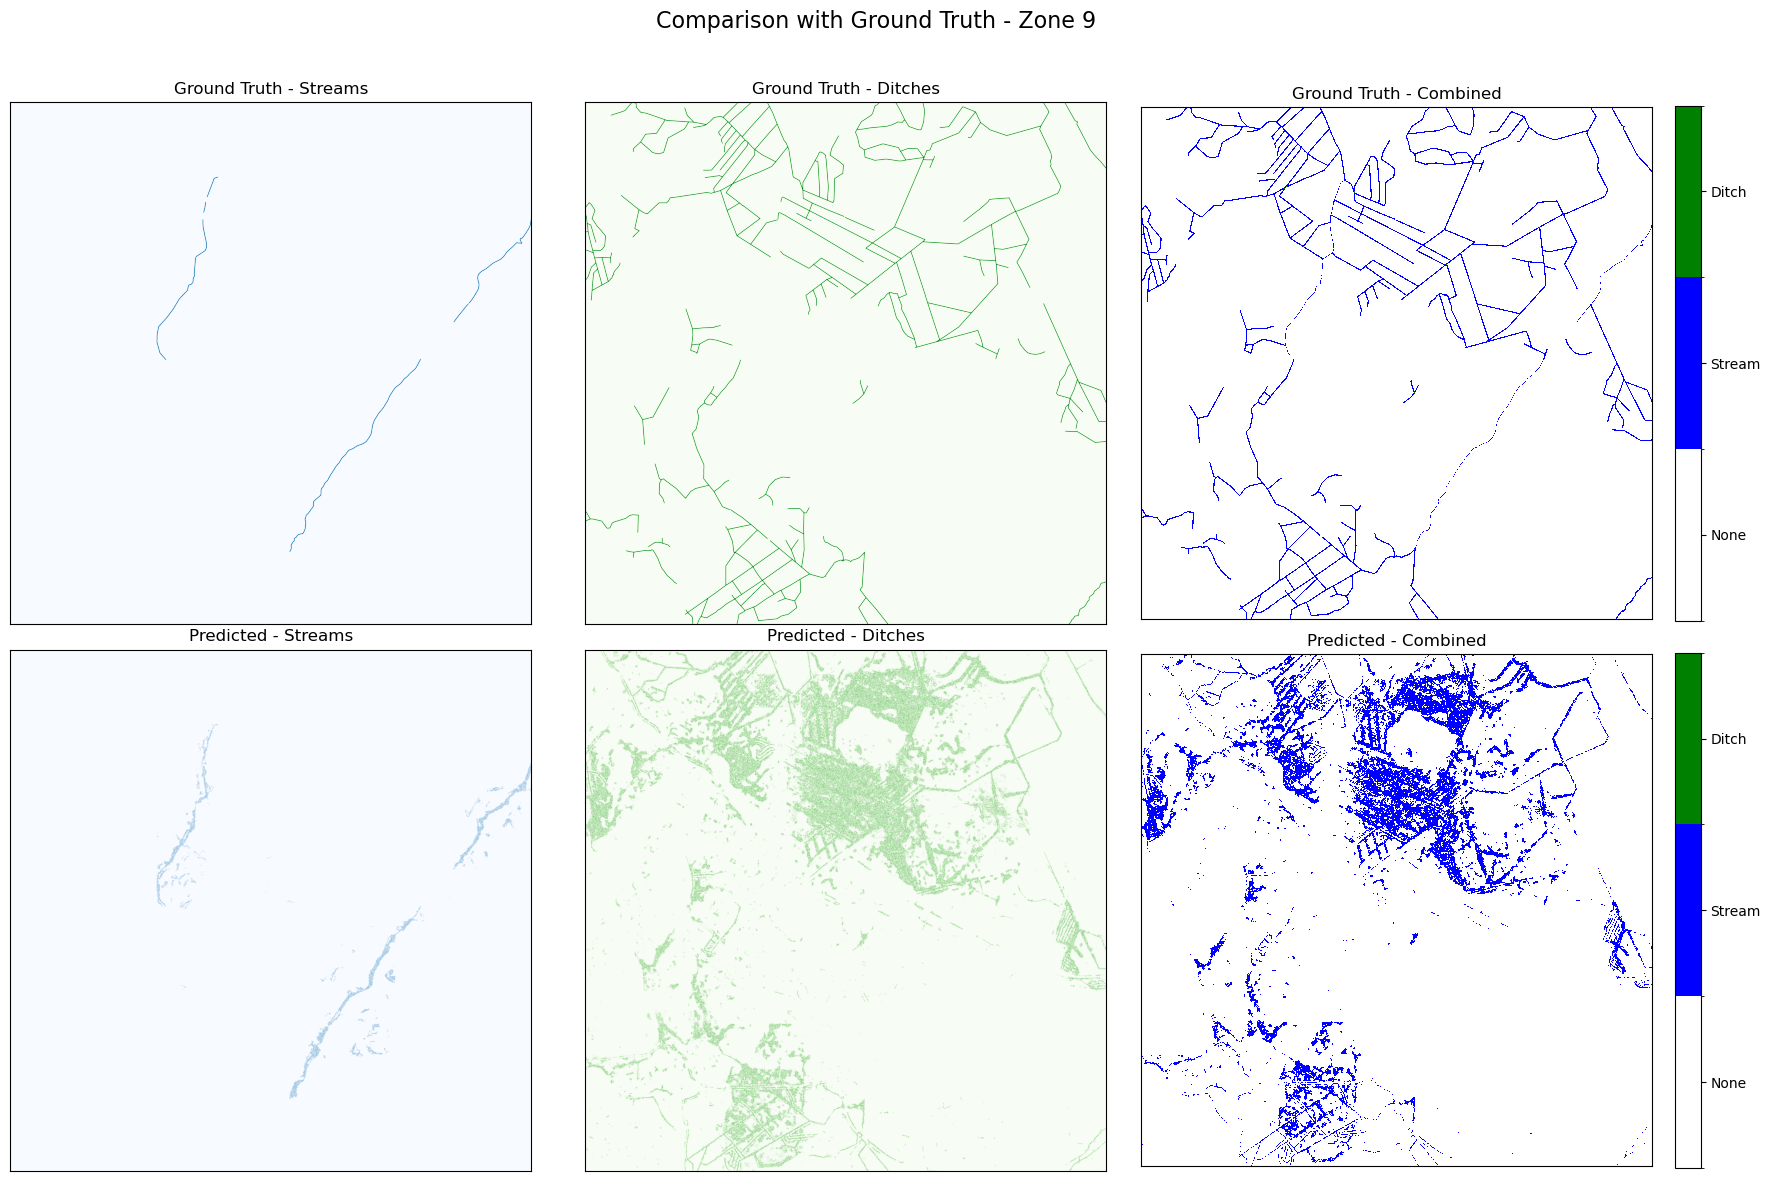

INFO:__main__:Saved visualizations for zone zone_9 to ../02_Results
INFO:__main__:Saving predictions for zone_9 to Zarr file
INFO:__main__:Saved data for zone_9
INFO:__main__:Saved prediction results to Zarr file: ../02_Results/prediction_results_smote.zarr
INFO:__main__:Saved model 0 to ../02_Results/models/rf_model_0.joblib
INFO:__main__:Saved model 1 to ../02_Results/models/rf_model_1.joblib
INFO:__main__:Saved model 2 to ../02_Results/models/rf_model_2.joblib
INFO:__main__:Saved model 3 to ../02_Results/models/rf_model_3.joblib
INFO:__main__:Saved model 4 to ../02_Results/models/rf_model_4.joblib
INFO:__main__:Saved model 5 to ../02_Results/models/rf_model_5.joblib
INFO:__main__:Saved model 6 to ../02_Results/models/rf_model_6.joblib
INFO:__main__:Saved model 7 to ../02_Results/models/rf_model_7.joblib
INFO:__main__:Saved model 8 to ../02_Results/models/rf_model_8.joblib
INFO:__main__:Processing complete.
INFO:__main__:Making predictions...
INFO:__main__:
Cohen's Kappa Metrics:
INF


Cohen's Kappa Metrics:
  Binary (Water vs Background) Kappa: 0.3743
  Stream vs Background Kappa: 0.4349
  Ditch vs Background Kappa: 0.3698
  Multi-class Kappa: 0.3750


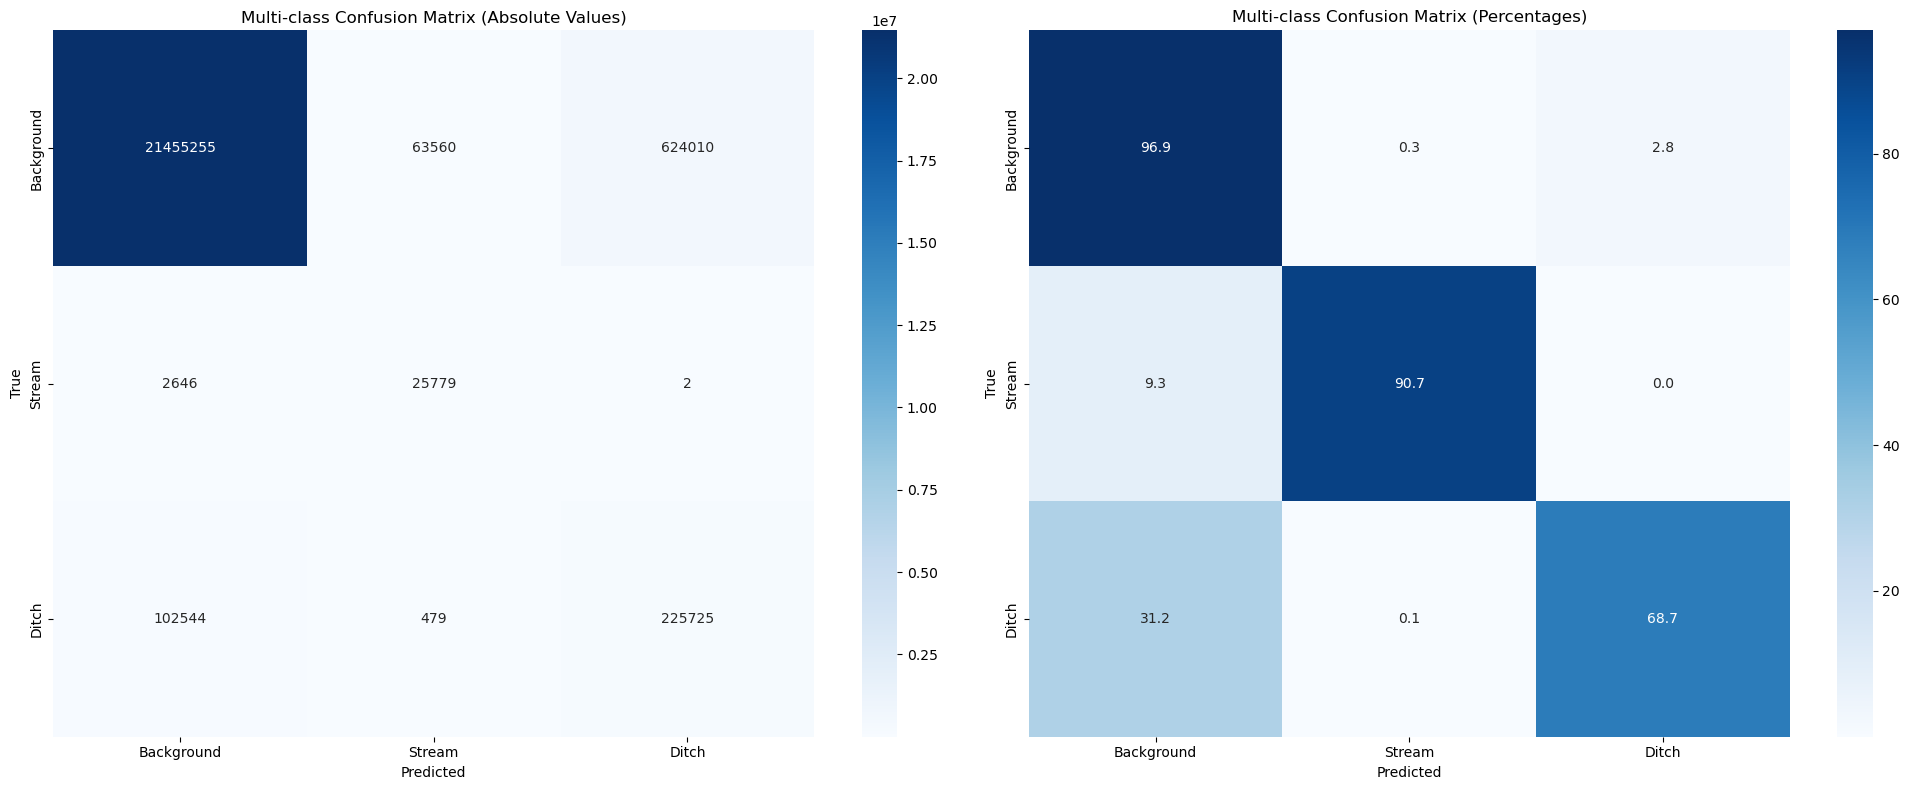

INFO:__main__:Generating feature importance plot...


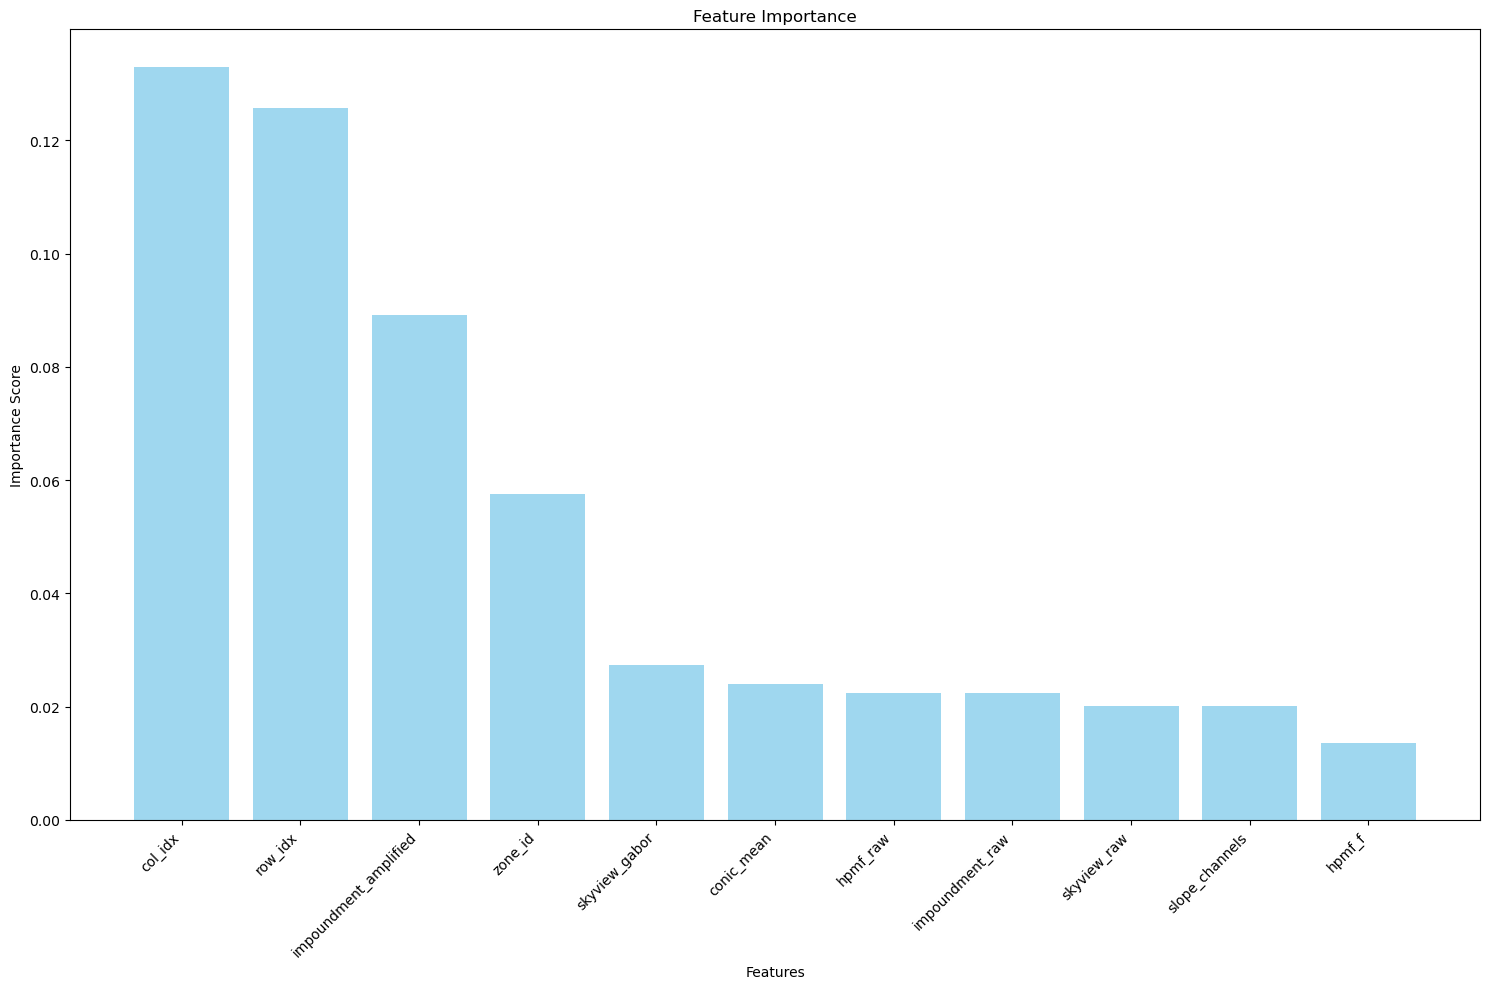

INFO:__main__:Generating ROC curves...


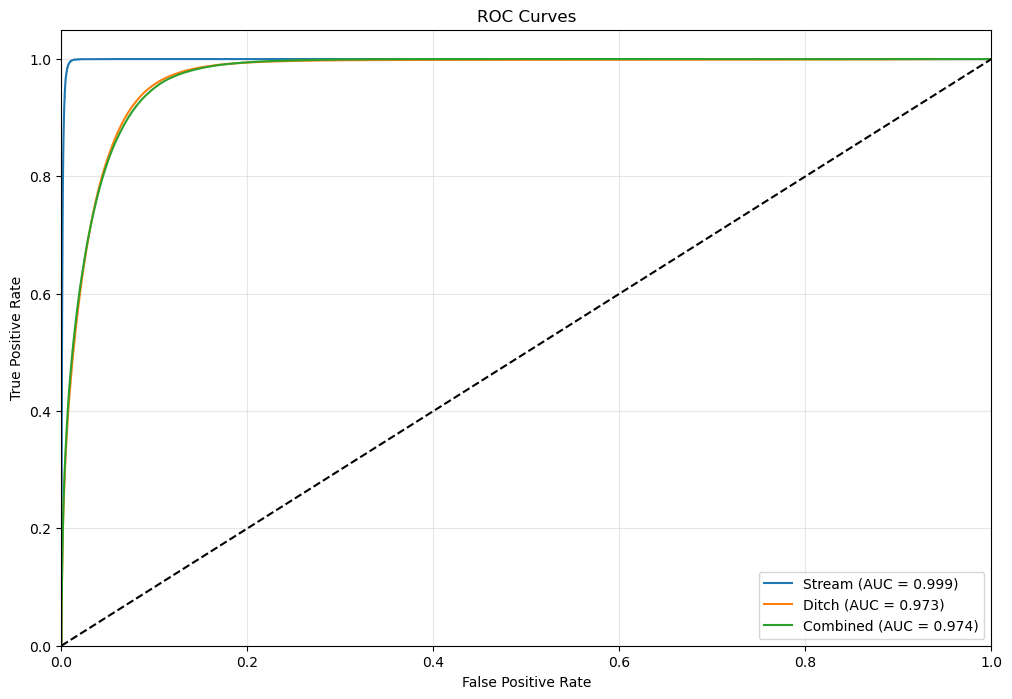

INFO:__main__:Generating precision-recall curves...


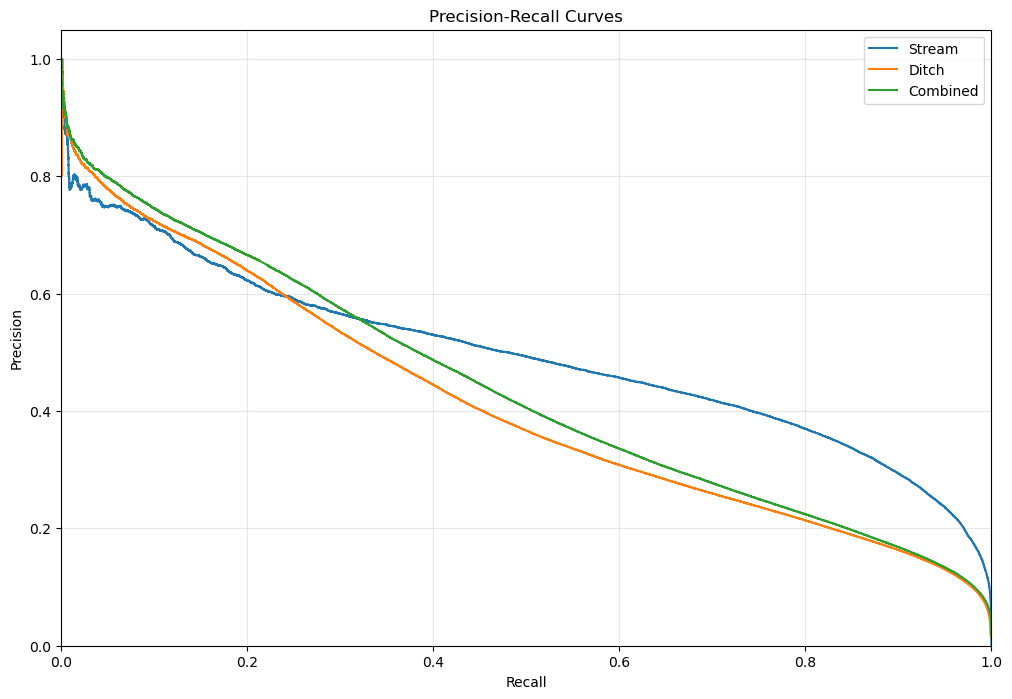

INFO:__main__:All visualizations have been saved as PNG files.


Memory usage: 10185.18 MB


In [1]:
# Clauden koodi...

import multiprocessing
import logging
import numpy as np
import numcodecs
import os
import traceback
import pandas as pd
import datetime
from datetime import datetime
import gc
import re
import zarr
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (cohen_kappa_score, accuracy_score, recall_score,
                             precision_score, confusion_matrix, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, auc, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import joblib
import psutil
import rasterio
from rasterio.transform import from_origin
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from zarr_processing import load_data_parallel, process_zarr_chunk, load_data_parallel_2
from spatial_coord import zone_boundaries

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# File paths
zarr_file = "zones_data_2.zarr"
output_path = "../03_Figures/smote_final" #changed from smote2_visualization
results = "../02_Results"

# Make sure output directory exists
os.makedirs(output_path, exist_ok=True)

def generate_spatial_indices(spatial_shape):
    """Generate row and column indices for a given spatial shape."""
    total_pixels = spatial_shape[0] * spatial_shape[1]
    row_indices = np.array([i // spatial_shape[1] for i in range(total_pixels)])
    col_indices = np.array([i % spatial_shape[1] for i in range(total_pixels)])
    return row_indices, col_indices

def generate_and_store_spatial_indices():
    """Generate and store spatial indices for all zones in the zarr file."""
    # Import your zone_boundaries dictionary
    from spatial_coord import zone_boundaries
    
    # Open the main zarr file
    root = zarr.open(zarr_file, mode='r+')  # Use 'r+' for read/write
    
    for zone_name in root.keys():
        zone = root[zone_name]
        
        # Extract zone_id properly
        try:
            # Adjust this parsing logic to match your actual zone naming convention
            zone_id = int(zone_name.split('_')[1]) - 1  # Convert to 0-indexed
            
            # Store the zone_id as metadata
            zone.attrs['zone_id'] = zone_id
            
            # Check if this zone_id has defined boundaries
            if zone_id not in zone_boundaries:
                logger.warning(f"Zone ID {zone_id} (from {zone_name}) not found in boundaries dictionary")
                continue
                
        except (IndexError, ValueError) as e:
            logger.warning(f"Could not extract zone ID from {zone_name}: {e}")
            continue
            
        # Get the boundaries for this zone
        ul_x, ul_y = zone_boundaries[zone_id]["upper_left"]
        lr_x, lr_y = zone_boundaries[zone_id]["lower_right"]
        
        # Store boundary information in metadata
        zone.attrs['geospatial_bounds'] = {
            'upper_left': (ul_x, ul_y),
            'lower_right': (lr_x, lr_y),
            'width': lr_x - ul_x,
            'height': ul_y - lr_y
        }
        
        # Create a spatial array if it doesn't exist
        if 'spatial' not in zone:
            # Create a simple array with geotransform info
            # Use GDAL-like geotransform: [origin_x, pixel_width, 0, origin_y, 0, pixel_height]
            pixel_width = (lr_x - ul_x) / 5000
            pixel_height = (lr_y - ul_y) / 5000  # Negative because y decreases as you go down
            
            geotransform = np.array([ul_x, pixel_width, 0, ul_y, 0, pixel_height])
            zone.create_dataset('spatial', data=geotransform)
            
        # Check if row/col indices already exist
        if 'row_idx' in zone and 'col_idx' in zone:
            logger.info(f"Spatial indices already exist for {zone_name}")
            continue
            
        # Generate row and column indices - standard 5000x5000 grid
        spatial_shape = (5000, 5000)
        total_pixels = spatial_shape[0] * spatial_shape[1]
        row_indices = np.array([i // spatial_shape[1] for i in range(total_pixels)])
        col_indices = np.array([i % spatial_shape[1] for i in range(total_pixels)])
        
        # Store the indices
        zone.create_dataset('row_idx', data=row_indices, shape=row_indices.shape, dtype=row_indices.dtype)
        zone.create_dataset('col_idx', data=col_indices, shape=col_indices.shape, dtype=col_indices.dtype)
        
        logger.info(f"Generated and stored spatial indices for {zone_name}")

def load_zone_data(zarr_file, zone_name, selected_features):
    """Load data for a specific zone with selected features."""
    try:
        root = zarr.open(zarr_file, mode='r')
        zone = root[zone_name]
        
        # Check if this zone has the target variable
        if 'label_3m' not in zone.keys():
            logger.warning(f"Zone {zone_name} does not have label_3m, skipping")
            return None
        
        # Create a dictionary to store data
        zone_data = {'zone_id': []}
        
        # Get spatial indices
        if 'row_idx' in zone and 'col_idx' in zone:
            row_idx = zone['row_idx'][:]
            col_idx = zone['col_idx'][:]
        else:
            # Generate spatial indices if they don't exist
            spatial_shape = (5000, 5000)  # Adjust based on your actual data
            row_idx, col_idx = generate_spatial_indices(spatial_shape)
            
        # Load the target variable
        labels = zone['label_3m'][:]
        
        # Add zone_id (extracted from zone_name)
        try:
            zone_id = int(zone_name.split('_')[1]) - 1  # Convert to 0-indexed
            zone_data['zone_id'] = [zone_id] * len(labels)
        except (IndexError, ValueError):
            logger.warning(f"Could not extract zone ID from {zone_name}")
            zone_data['zone_id'] = [0] * len(labels)  # Default to 0
        
        # Add spatial indices
        zone_data['row_idx'] = row_idx
        zone_data['col_idx'] = col_idx
        
        # Add labels
        zone_data['label_3m'] = labels
        
        # Add selected features
        for feature in selected_features:
            if feature in zone.keys():
                zone_data[feature] = zone[feature][:]
            else:
                logger.warning(f"Feature {feature} not found in {zone_name}")
                zone_data[feature] = np.zeros_like(labels)  # Default to zeros
        
        # Convert to DataFrame
        df = pd.DataFrame(zone_data)
        logger.info(f"Loaded data from {zone_name}, shape: {df.shape}")
        
        return df
        
    except Exception as e:
        logger.error(f"Error loading data from {zone_name}: {e}")
        return None

def print_memory_usage():
    """Print current memory usage."""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def ensure_writable(obj):
    """Ensures an object (NumPy array or Pandas DataFrame) is writable."""
    if isinstance(obj, np.ndarray):
        if not obj.flags.writeable:  # Correct spelling is 'writeable'
            obj = obj.copy()
            obj.flags.writeable = True
        return obj
    elif isinstance(obj, pd.DataFrame):
        return obj.copy()  # Ensure DataFrame is writable
    elif isinstance(obj, pd.Series):
        return obj.copy()
    return obj  # Return as is if the type is unknown

def create_custom_colormaps():
    """Create custom colormaps for visualization."""
    # Custom colormap for streams (blue-based)
    stream_colors = ['#ffffff', '#e6f3ff', '#b3d9ff', '#80bfff', '#4da6ff', '#1a8cff', '#0066cc']
    stream_cmap = LinearSegmentedColormap.from_list('stream_blues', stream_colors)
    
    # Custom colormap for ditches (green-based)
    ditch_colors = ['#ffffff', '#e6ffe6', '#b3ffb3', '#80ff80', '#4dff4d', '#1aff1a', '#00cc00']
    ditch_cmap = LinearSegmentedColormap.from_list('ditch_greens', ditch_colors)
    
    # Custom colormap for combined visualization
    combined_colors = ['#ffffff', '#4da6ff', '#00cc00']  # white, blue, green
    combined_cmap = LinearSegmentedColormap.from_list('combined', combined_colors)
    
    return stream_cmap, ditch_cmap, combined_cmap

def plot_confusion_matrices(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Plot confusion matrix with percentage and absolute values."""
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot absolute values
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title(f'{title} (Absolute Values)')
    ax1.set_xticklabels(class_names)
    ax1.set_yticklabels(class_names)
    
    # Plot percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title(f'{title} (Percentages)')
    ax2.set_xticklabels(class_names)
    ax2.set_yticklabels(class_names)
    
    plt.tight_layout()
    #plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300) #changed to redirect to an ouput folder
    plt.savefig(os.path.join(output_path, f"{title.lower().replace(' ', '_')}.png"), dpi=300)
    plt.show()

def plot_feature_importance(feature_importances, feature_names, title="Feature Importance"):
    """Plot feature importance."""
    # Sort features by importance
    indices = np.argsort(feature_importances)[::-1]
    
    plt.figure(figsize=(15, 10))
    
    # Plot top 20 features (or all if less than 20)
    n_features = min(20, len(feature_names))
    plt.bar(range(n_features), 
            feature_importances[indices][:n_features],
            align='center',
            alpha=0.8,
            color='skyblue')
    
    plt.xticks(range(n_features), 
               [feature_names[i] for i in indices][:n_features], 
               rotation=45,
               ha='right')
    
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{title.lower().replace(' ', '_')}.png"), dpi=300)
    plt.show()

def plot_roc_curves(y_test, y_prob, title="ROC Curves"):
    """Plot ROC curves for stream and ditch classification."""
    plt.figure(figsize=(12, 8))
    
    # Plot ROC curve for stream class
    fpr_stream, tpr_stream, _ = roc_curve(y_test, y_prob[:, 0], pos_label=1)
    plt.plot(fpr_stream, tpr_stream, label=f'Stream (AUC = {roc_auc_score(y_test == 1, y_prob[:, 0]):.3f})')
    
    # Plot ROC curve for ditch class
    fpr_ditch, tpr_ditch, _ = roc_curve(y_test, y_prob[:, 1], pos_label=2)
    plt.plot(fpr_ditch, tpr_ditch, label=f'Ditch (AUC = {roc_auc_score(y_test == 2, y_prob[:, 1]):.3f})')
    
    # Plot ROC curve for combined prediction
    fpr_combined, tpr_combined, _ = roc_curve(y_test > 0, y_prob.sum(axis=1))
    plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {roc_auc_score(y_test > 0, y_prob.sum(axis=1)):.3f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_path, f"{title.lower().replace(' ', '_')}.png"), dpi=300)
    plt.show()

def plot_precision_recall_curves(y_test, y_prob, title="Precision-Recall Curves"):
    """Plot precision-recall curves for stream and ditch classification."""
    plt.figure(figsize=(12, 8))
    
    # Plot PR curve for stream class
    precision_stream, recall_stream, _ = precision_recall_curve(y_test == 1, y_prob[:, 0])
    plt.plot(recall_stream, precision_stream, label='Stream')
    
    # Plot PR curve for ditch class
    precision_ditch, recall_ditch, _ = precision_recall_curve(y_test == 2, y_prob[:, 1])
    plt.plot(recall_ditch, precision_ditch, label='Ditch')
    
    # Plot PR curve for combined prediction (any water feature vs background)
    precision_combined, recall_combined, _ = precision_recall_curve(y_test > 0, y_prob.sum(axis=1))
    plt.plot(recall_combined, precision_combined, label='Combined')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_path, f"{title.lower().replace(' ', '_')}.png"), dpi=300)
    plt.show()


def plot_roc_with_thresholds(y_test, y_prob, ax):
    """Plot ROC curves with threshold markers."""
    # Stream class
    fpr_stream, tpr_stream, thresholds_stream = roc_curve(y_test == 1, y_prob[:, 0])
    roc_auc_stream = auc(fpr_stream, tpr_stream)
    ax.plot(fpr_stream, tpr_stream, 'b-', label=f'Stream (AUC = {roc_auc_stream:.3f})')
    
    # Ditch class
    fpr_ditch, tpr_ditch, thresholds_ditch = roc_curve(y_test == 2, y_prob[:, 1])
    roc_auc_ditch = auc(fpr_ditch, tpr_ditch)
    ax.plot(fpr_ditch, tpr_ditch, 'g-', label=f'Ditch (AUC = {roc_auc_ditch:.3f})')
    
    # Combined
    fpr_combined, tpr_combined, thresholds_combined = roc_curve(y_test > 0, y_prob.sum(axis=1)/2)
    roc_auc_combined = auc(fpr_combined, tpr_combined)
    ax.plot(fpr_combined, tpr_combined, 'r-', label=f'Combined (AUC = {roc_auc_combined:.3f})')
    
    # Mark thresholds
    for i, threshold in enumerate(np.linspace(0.1, 0.9, 9)):
        # Find closest threshold for each class
        idx_stream = np.argmin(np.abs(thresholds_stream - threshold))
        idx_ditch = np.argmin(np.abs(thresholds_ditch - threshold))
        idx_combined = np.argmin(np.abs(thresholds_combined - threshold))
        
        if idx_stream < len(fpr_stream):
            ax.plot(fpr_stream[idx_stream], tpr_stream[idx_stream], 'bo', markersize=4)
            if i % 2 == 0:  # Label every other threshold for clarity
                ax.annotate(f'{threshold:.1f}', 
                           (fpr_stream[idx_stream], tpr_stream[idx_stream]),
                           textcoords="offset points", xytext=(0,10), ha='center')
        
        if idx_ditch < len(fpr_ditch):
            ax.plot(fpr_ditch[idx_ditch], tpr_ditch[idx_ditch], 'go', markersize=4)
        
        if idx_combined < len(fpr_combined):
            ax.plot(fpr_combined[idx_combined], tpr_combined[idx_combined], 'ro', markersize=4)
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves with Thresholds')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)


#####################################
#                                   #
#   Visualisation starts from here  #
#                                   #
#####################################

def create_ground_truth_visualization(zone_data, spatial_shape=(5000, 5000)):
    """Create ground truth visualization arrays from zone data."""
    # Initialize ground truth arrays
    gt_streams = np.zeros(spatial_shape, dtype=np.int8)
    gt_ditches = np.zeros(spatial_shape, dtype=np.int8)
    
    # Check if we have the necessary columns
    if 'row_idx' in zone_data.columns and 'col_idx' in zone_data.columns and 'label_3m' in zone_data.columns:
        # Extract data
        rows = zone_data['row_idx'].values
        cols = zone_data['col_idx'].values
        labels = zone_data['label_3m'].values
        
        # Fill in ground truth arrays
        for row, col, label in zip(rows, cols, labels):
            # Convert row and col to integers and ensure within bounds
            row_idx = int(min(row, spatial_shape[0]-1))
            col_idx = int(min(col, spatial_shape[1]-1))
            
            if 0 <= row_idx < spatial_shape[0] and 0 <= col_idx < spatial_shape[1]:
                if label == 1:  # Stream
                    gt_streams[row_idx, col_idx] = 1
                elif label == 2:  # Ditch
                    gt_ditches[row_idx, col_idx] = 1
    
    return {
        'streams': gt_streams,
        'ditches': gt_ditches
    }

def create_custom_colormaps():
    """Create custom colormaps for better visualization."""
    # Stream colormap (blue)
    stream_cmap = plt.cm.Blues
    
    # Ditch colormap (green)
    ditch_cmap = plt.cm.Greens
    
    # Combined colormap (both)
    combined_cmap = plt.cm.coolwarm
    
    return stream_cmap, ditch_cmap, combined_cmap

def plot_predictions(predictions, title_prefix="Predicted Water Features", output_path="."):
    """Plot spatial predictions with custom colormaps for better visualization."""
    
    stream_cmap, ditch_cmap, combined_cmap = create_custom_colormaps()
    
    # Create a figure with subplots for probabilities and predictions
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Check if predictions are completely empty
    if np.max(predictions['spatial']['prob_streams']) == 0 and np.max(predictions['spatial']['prob_ditches']) == 0:
        print("Warning: No predictions found in the data. Visualizations will be empty.")
    
    # Apply Gaussian filter to smooth visualization (optional)
    prob_streams_smooth = gaussian_filter(predictions['spatial']['prob_streams'], sigma=1)
    prob_ditches_smooth = gaussian_filter(predictions['spatial']['prob_ditches'], sigma=1)
    prob_combined_smooth = gaussian_filter(predictions['spatial']['prob_combined'], sigma=1)
    
    # Plot probability maps
    vmax_streams = max(0.7, np.max(prob_streams_smooth))
    im1 = axes[0, 0].imshow(prob_streams_smooth, cmap=stream_cmap, vmax=vmax_streams)
    axes[0, 0].set_title('Stream Probability')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    vmax_ditches = max(0.7, np.max(prob_ditches_smooth))
    im2 = axes[0, 1].imshow(prob_ditches_smooth, cmap=ditch_cmap, vmax=vmax_ditches)
    axes[0, 1].set_title('Ditch Probability')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    vmax_combined = max(0.7, np.max(prob_combined_smooth))
    im3 = axes[0, 2].imshow(prob_combined_smooth, cmap=combined_cmap, vmax=vmax_combined)
    axes[0, 2].set_title('Combined Probability')
    plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Plot binary predictions
    axes[1, 0].imshow(predictions['spatial']['pred_streams'], cmap='Blues')
    axes[1, 0].set_title('Stream Prediction')
    
    axes[1, 1].imshow(predictions['spatial']['pred_ditches'], cmap='Greens')
    axes[1, 1].set_title('Ditch Prediction')
    
    # Plot combined prediction with custom colormap
    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'green'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    # Create combined visualization with different colors for streams and ditches
    combined_viz = predictions['spatial']['pred_combined']
    im4 = axes[1, 2].imshow(combined_viz, cmap=cmap, norm=norm)
    axes[1, 2].set_title('Combined Prediction')
    
    # Add a colorbar to explain the values
    cbar = plt.colorbar(im4, ax=axes[1, 2], ticks=[0, 1, 2], fraction=0.046, pad=0.04)
    cbar.set_ticklabels(['None', 'Stream', 'Ditch'])
    
    # Remove axis ticks for all subplots
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f"{title_prefix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the subtitle
    
    # Save figure
    plt.savefig(os.path.join(output_path, f"{title_prefix.lower().replace(' ', '_')}.png"), dpi=300, bbox_inches='tight')
    plt.show()

def compare_predictions_with_ground_truth(predictions, ground_truth, title_prefix="Comparison with Ground Truth", output_path="."):
    """Compare predictions with ground truth to visualize model performance."""
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Create custom colormaps
    stream_cmap, ditch_cmap, combined_cmap = create_custom_colormaps()
    
    # Plot ground truth
    axes[0, 0].imshow(ground_truth['streams'], cmap='Blues')
    axes[0, 0].set_title('Ground Truth - Streams')
    
    axes[0, 1].imshow(ground_truth['ditches'], cmap='Greens')
    axes[0, 1].set_title('Ground Truth - Ditches')
    
    # Create combined ground truth
    combined_gt = np.zeros_like(ground_truth['streams'])
    combined_gt[ground_truth['streams'] == 1] = 1
    combined_gt[ground_truth['ditches'] == 1] = 2
    
    cmap_gt = plt.cm.colors.ListedColormap(['white', 'blue', 'green'])
    bounds_gt = [-0.5, 0.5, 1.5, 2.5]
    norm_gt = plt.cm.colors.BoundaryNorm(bounds_gt, cmap_gt.N)
    
    im_gt = axes[0, 2].imshow(combined_gt, cmap=cmap_gt, norm=norm_gt)
    axes[0, 2].set_title('Ground Truth - Combined')
    cbar_gt = plt.colorbar(im_gt, ax=axes[0, 2], ticks=[0, 1, 2], fraction=0.046, pad=0.04)
    cbar_gt.set_ticklabels(['None', 'Stream', 'Ditch'])
    
    # Plot predictions
    axes[1, 0].imshow(predictions['spatial']['pred_streams'], cmap='Blues')
    axes[1, 0].set_title('Predicted - Streams')
    
    axes[1, 1].imshow(predictions['spatial']['pred_ditches'], cmap='Greens')
    axes[1, 1].set_title('Predicted - Ditches')
    
    cmap_pred = plt.cm.colors.ListedColormap(['white', 'blue', 'green'])
    bounds_pred = [-0.5, 0.5, 1.5, 2.5]
    norm_pred = plt.cm.colors.BoundaryNorm(bounds_pred, cmap_pred.N)
    
    im_pred = axes[1, 2].imshow(predictions['spatial']['pred_combined'], cmap=cmap_pred, norm=norm_pred)
    axes[1, 2].set_title('Predicted - Combined')
    cbar_pred = plt.colorbar(im_pred, ax=axes[1, 2], ticks=[0, 1, 2], fraction=0.046, pad=0.04)
    cbar_pred.set_ticklabels(['None', 'Stream', 'Ditch'])
    
    # Remove axis ticks for all subplots
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f"{title_prefix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    
    # Save figure
    #plt.savefig(os.path.join(output_path, f"{title_prefix.lower().replace(' ', '_')}.png"), dpi=300, bbox_inches='tight')
    #plt.show()
    # Make sure the output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Create a safe filename
    safe_filename = re.sub(r'[^\w\-_\.]', '_', title_prefix.lower().replace(' ', '_'))
    output_file = os.path.join(output_path, f"{safe_filename}.png")
    
    # Save figure with explicit close to avoid memory issues
    try:
        print(f"Saving figure to: {output_file}")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Figure saved successfully")
    except Exception as e:
        print(f"Error saving figure: {e}")
    
    plt.show()
    plt.close(fig)  # Explicitly close the figure to free memory

def calculate_spatial_metrics(predictions, ground_truth):
    """Calculate performance metrics for spatial predictions."""
    # Extract binary predictions
    pred_streams = predictions['spatial']['pred_streams']
    pred_ditches = predictions['spatial']['pred_ditches']
    
    # Extract ground truth
    gt_streams = ground_truth['streams']
    gt_ditches = ground_truth['ditches']
    
    # Calculate metrics for streams
    stream_metrics = {
        'precision': precision_score(gt_streams.flatten(), pred_streams.flatten(), zero_division=0),
        'recall': recall_score(gt_streams.flatten(), pred_streams.flatten(), zero_division=0),
        'f1': f1_score(gt_streams.flatten(), pred_streams.flatten(), zero_division=0), 
    }
    
    # Calculate metrics for ditches
    ditch_metrics = {
        'precision': precision_score(gt_ditches.flatten(), pred_ditches.flatten(), zero_division=0),
        'recall': recall_score(gt_ditches.flatten(), pred_ditches.flatten(), zero_division=0),
        'f1': f1_score(gt_ditches.flatten(), pred_ditches.flatten(), zero_division=0)
    }
    
    # Calculate metrics for combined prediction (any water feature)
    pred_combined = (pred_streams + pred_ditches > 0).astype(np.int8)
    gt_combined = (gt_streams + gt_ditches > 0).astype(np.int8)
    
    combined_metrics = {
        'precision': precision_score(gt_combined.flatten(), pred_combined.flatten(), zero_division=0),
        'recall': recall_score(gt_combined.flatten(), pred_combined.flatten(), zero_division=0),
        'f1': f1_score(gt_combined.flatten(), pred_combined.flatten(), zero_division=0)
    }
    
    return {
        'streams': stream_metrics,
        'ditches': ditch_metrics,
        'combined': combined_metrics
    }


def setup_zarr_output(output_path, zone_names=None):
    """
    Create the initial Zarr structure for saving predictions.
    
    Args:
        output_path (str): Path to save the Zarr store
        zone_names (list, optional): List of zone names to include in the structure
    """
    # Define compression parameters first
    compression_params = dict(
        compressor=zarr.Blosc(cname='zstd', clevel=3, shuffle=zarr.Blosc.SHUFFLE)
    )

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Open/create the Zarr file
    root = zarr.open(output_path, mode="w")

    # Add root metadata
    root.attrs['description'] = 'Water feature predictions from Random Forest models'
    root.attrs['creation_date'] = datetime.now().isoformat()
    root.attrs['model_type'] = 'Random Forest with SMOTE'

    # Create main predictions group
    predictions_group = root.create_group("predictions")
    predictions_group.attrs['class_labels'] = ['background', 'stream', 'ditch']

    # Create raw and spatial groups
    raw_group = predictions_group.create_group("raw")
    spatial_group = predictions_group.create_group("spatial")

    # Ensure zone_names is always a list, even if not provided
    if zone_names is None:
        zone_names = []

    # Add zone names as an attribute
    root.attrs['zone_names'] = zone_names

    # Create a group for each zone
    for zone in zone_names:
        spatial_group.create_group(zone)
    
    return root, predictions_group, raw_group, spatial_group, compression_params



def process_and_visualize_zone(zarr_file, zone_name, selected_features, output_path, 
                               trained_models=None, X_test=None, y_test=None, test_indices=None, 
                               zarr_output=None, compression_params=None):
    """
    Process data for a specific zone and visualize the results using pre-trained models.
    
    Parameters:
    -----------
    zarr_file : str
        Path to the zarr file containing the data
    zone_name : str
        Name of the zone to process (e.g., "zone_2", "zone_5", "zone_9")
    selected_features : list
        List of feature names to use
    output_path : str
        Path to save the output visualizations
    trained_models : list, optional
        List of pre-trained Random Forest models from main()
    X_test : pandas.DataFrame, optional
        Test features from main()
    y_test : pandas.Series, optional
        Test labels from main()
    test_indices : numpy.ndarray, optional
        Spatial indices for test data from main()
    """
    logger.info(f"Processing zone: {zone_name}")

    # Make sure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Extract zone_id as integer from zone_name for filtering
    try:
        zone_id = int(zone_name.split('_')[1]) - 1  # Convert to 0-indexed to match load_zone_data
    except (IndexError, ValueError):
        logger.error(f"Invalid zone name format: {zone_name}. Expected format: 'zone_X'")
        return

    # Load zone data (only for ground truth visualization)
    # Note: we use the actual zarr zone key format which might be different from zone_name
    zarr_zone_name = f"zone_{zone_id + 1}"  # Convert back to 1-indexed for zarr access
    zone_data = load_zone_data(zarr_file, zarr_zone_name, selected_features)
    
    if zone_data is None or len(zone_data) == 0:
        logger.warning(f"No data available for zone {zone_name}")
        return
    
    # Filter test data for this specific zone
    zone_test_data = None
    zone_test_indices = None
    
    if X_test is not None and 'zone_id' in X_test.columns:
        # Filter test data for this specific zone - match by integer zone_id, not string name
        zone_mask = X_test['zone_id'] == zone_id  # Use the integer ID, not the name
        
        # In case zone_id is stored differently - try alternate formats
        if sum(zone_mask) == 0:
            # Try with 1-indexed ID
            zone_mask = X_test['zone_id'] == (zone_id + 1)
            
            # Try with string name if numeric matching fails
            if sum(zone_mask) == 0:
                zone_mask = X_test['zone_id'] == zone_name
                
                if sum(zone_mask) == 0:
                    logger.warning(f"Could not find any data for zone {zone_name} in test set.")
                    # Print sample of zone_id values to help debug
                    logger.info(f"Sample zone_id values: {X_test['zone_id'].iloc[:10].tolist()}")
                    return
        
        logger.info(f"Found {sum(zone_mask)} samples for zone {zone_name}")
        
        zone_test_data = X_test[zone_mask]
        y_test_zone = y_test[zone_mask] if y_test is not None else None
        
        # Filter test indices for this zone
        if test_indices is not None:
            zone_test_indices = test_indices[zone_mask]
    else:
        # If no zone information in test data, use all test data
        logger.warning("No zone_id column found in test data - using all test data")
        zone_test_data = X_test
        y_test_zone = y_test
        zone_test_indices = test_indices
    
    if zone_test_data is None or len(zone_test_data) == 0:
        logger.warning(f"No test data available for zone {zone_name}")
        return
    
    # Ensure correct columns for prediction
    feature_cols = trained_models[0].feature_names_in_.tolist()
    zone_test_features = zone_test_data[feature_cols]
    
    # Make predictions using pre-trained models
    logger.info(f"Making predictions for {zone_name} using pre-trained models...")
    
    if trained_models is None or len(trained_models) == 0:
        logger.warning("No trained models provided. Cannot make predictions.")
        return
    
    # Initialize a uniform array to hold all class probabilities
    n_samples = len(zone_test_features)
    n_classes = 3  # [background, stream, ditch]
    
    # Final array to hold average probabilities for classes 0, 1, 2
    final_probabilities = np.zeros((n_samples, n_classes))
    model_count = np.zeros(n_classes)  # Count models that have each class
    
    # Process each model's predictions individually and align class indices
    for model in trained_models:
        y_prob = model.predict_proba(zone_test_features)
        classes = model.classes_
        
        # Map each class to the appropriate index in final_probabilities
        for i, class_label in enumerate(classes):
            cl = int(class_label)  # Ensure class_label is an integer
            if 0 <= cl < n_classes:  # Only include classes 0, 1, 2
                final_probabilities[:, cl] += y_prob[:, i]
                model_count[cl] += 1
    
    # Average predictions by dividing by the number of models that predicted each class
    for i in range(n_classes):
        if model_count[i] > 0:
            final_probabilities[:, i] /= model_count[i]
    
    # Extract stream and ditch probabilities (classes 1 and 2)
    y_prob_final = final_probabilities[:, 1:3]  # Just get stream and ditch columns
    
    # Reshape predictions for visualization
    spatial_shape = (5000, 5000)  # Adjust based on actual data
    predictions = reshape_predictions_for_visualization(y_prob_final, zone_test_indices, spatial_shape)
    
    # Create ground truth visualization data
    ground_truth = create_ground_truth_visualization(zone_data, spatial_shape)

    # Plot the predictions with the zone name in the filename
    plot_predictions(predictions, 
                    title_prefix=f"Predicted Water Features - Zone {zone_id+1}",  # Use zone number in title
                    output_path=output_path)
    
    # Compare predictions with ground truth
    compare_predictions_with_ground_truth(predictions, ground_truth, 
                                        title_prefix=f"Comparison with Ground Truth - Zone {zone_id+1}",
                                        output_path=output_path)
    
    logger.info(f"Saved visualizations for zone {zone_name} to {output_path}")

    # After predictions are made and reshaped:
    if zarr_output is not None:
        root, predictions_group, raw_group, spatial_group = zarr_output
        
        # Extract zone_id as integer
        try:
            zone_id = int(zone_name.split('_')[1])
        except (IndexError, ValueError):
            logger.error(f"Invalid zone name format: {zone_name}. Expected format: 'zone_X'")
            zone_id = zone_name  # Use the full name as fallback
        
        # Create or get zone-specific group
        zone_group_name = f"zone_{zone_id}"
        if zone_group_name in predictions_group:
            zone_group = predictions_group[zone_group_name]
        else:
            zone_group = predictions_group.create_group(zone_group_name)
        
        # Save zone-specific predictions
        logger.info(f"Saving predictions for {zone_name} to Zarr file")
        
        # Save binary predictions for this zone
        zone_group.create_dataset("pred_streams", data=predictions['spatial']['pred_streams'], 
                                 dtype=np.int8, chunks=True, **compression_params)
        zone_group.create_dataset("pred_ditches", data=predictions['spatial']['pred_ditches'], 
                                 dtype=np.int8, chunks=True, **compression_params)
        zone_group.create_dataset("pred_combined", data=predictions['spatial']['pred_combined'], 
                                 dtype=np.int8, chunks=True, **compression_params)
        
        # Save probability maps for this zone
        zone_group.create_dataset("prob_streams", data=predictions['spatial']['prob_streams'], 
                                 dtype=np.float32, chunks=True, **compression_params)
        zone_group.create_dataset("prob_ditches", data=predictions['spatial']['prob_ditches'], 
                                 dtype=np.float32, chunks=True, **compression_params)
        zone_group.create_dataset("prob_combined", data=predictions['spatial']['prob_combined'], 
                                 dtype=np.float32, chunks=True, **compression_params)
        
        # Add zone-specific metadata
        zone_group.attrs['processed_date'] = datetime.now().isoformat()
        zone_group.attrs['pixel_shape'] = predictions['spatial']['pred_streams'].shape
        
        # If you have zone boundaries defined somewhere
        if 'zone_boundaries' in globals() and zone_name in zone_boundaries:
            zone_group.attrs['upper_left'] = zone_boundaries[zone_name]['upper_left']
            zone_group.attrs['lower_right'] = zone_boundaries[zone_name]['lower_right']
    
    # Close all figures to avoid overlapping in next iteration
    plt.close('all')
    
    return predictions

def process_selected_zones(zarr_file, selected_features, output_path, trained_models, X_test, y_test, test_indices, target_zones=None):
    """
    Process and visualize multiple zones, saving comprehensive data to Zarr.
    """
    # If no target zones are provided, use a default
    if target_zones is None:
        target_zones = ["zone_2", "zone_5", "zone_9"]
    
    # Create Zarr output structure
    output_zarr_file = os.path.join(output_path, "prediction_results_smote.zarr")
    
    # Use zarr.open_group to ensure file is properly saved and closed
    with zarr.open_group(output_zarr_file, mode="w") as root:
        # Create main groups
        predictions_group = root.create_group("predictions")
        predictions_group.attrs['class_labels'] = ['background', 'stream', 'ditch']

        # Create raw and spatial groups
        raw_group = predictions_group.create_group("raw")
        spatial_group = predictions_group.create_group("spatial")

        # Add root metadata
        root.attrs['description'] = 'Water feature predictions from Random Forest models'
        root.attrs['creation_date'] = datetime.now().isoformat()
        root.attrs['model_type'] = 'Random Forest with SMOTE'
        root.attrs['zone_names'] = target_zones

        # Compression parameters
        compression_params = {
            'compressor': zarr.Blosc(cname='zstd', clevel=3, shuffle=zarr.Blosc.SHUFFLE)
        }
        
        # Save global test data (inside the with block)
        raw_group.create_dataset("y_test", data=y_test.to_numpy().astype(np.int8), 
                                  chunks=True, **compression_params)

        if hasattr(X_test, 'to_numpy'):
            raw_group.create_dataset("X_test", data=X_test.to_numpy(), 
                                      chunks=True, **compression_params)

        if test_indices is not None:
            raw_group.create_dataset("test_indices", data=test_indices, 
                                      chunks=True, **compression_params)

        # Tracking zone details
        all_zone_details = {}
        all_zone_bounds = {}  # Ensure this is defined

        # Process each zone
        for zone_name in target_zones:
            logger.info(f"Processing {zone_name}")
            
            # Check if zone group already exists, if so, delete it
            if zone_name in spatial_group:
                del spatial_group[zone_name]
            
            # Create zone-specific group
            zone_group = spatial_group.create_group(zone_name)
            
            # Try to extract zone number
            try:
                zone_number = int(zone_name.split('_')[1])
            except (IndexError, ValueError):
                logger.error(f"Invalid zone name: {zone_name}")
                zone_number = None
            
            # Store zone metadata
            zone_metadata = {
                'name': zone_name,
                'number': zone_number,
                'processed_date': datetime.now().isoformat()
            }
            
            # Add metadata to zone group
            zone_group.attrs.update(zone_metadata)
            
            # Store zone details for overall tracking
            all_zone_details[zone_name] = zone_metadata
            
            # Process the zone
            predictions = process_and_visualize_zone(
                zarr_file=zarr_file,
                zone_name=zone_name,
                selected_features=selected_features,
                output_path=output_path,
                trained_models=trained_models,
                X_test=X_test,
                y_test=y_test,
                test_indices=test_indices,
                zarr_output=(root, predictions_group, raw_group, spatial_group),
                compression_params=compression_params  # Add this argument
            )
        
            # Ensure predictions exist before saving
            if predictions and 'spatial' in predictions:
                # Save spatial predictions for this zone
                for pred_type in ['pred_streams', 'pred_ditches', 'pred_combined', 
                                  'prob_streams', 'prob_ditches', 'prob_combined']:
                    if pred_type in predictions['spatial']:
                        zone_group.create_dataset(
                            pred_type, 
                            data=predictions['spatial'][pred_type], 
                            dtype=np.float32 if 'prob' in pred_type else np.int8,
                            chunks=True, 
                            **compression_params
                        )
                
                # Add zone-specific metadata
                zone_group.attrs['processed_date'] = datetime.now().isoformat()
                zone_group.attrs['zone_name'] = zone_name
                
                # Optional: Track zone boundaries
                if 'zone_boundaries' in globals():
                    zone_boundary = zone_boundaries.get(zone_name, {})
                    if zone_boundary:
                        zone_group.attrs['upper_left'] = zone_boundary.get('upper_left')
                        zone_group.attrs['lower_right'] = zone_boundary.get('lower_right')
                        all_zone_bounds[zone_name] = zone_boundary
            
            logger.info(f"Saved data for {zone_name}")
        
        # Add overall metadata about zones (inside the with block)
        predictions_group.attrs['processed_zones'] = target_zones
        
        # Optionally, save combined zone boundary information
        if all_zone_bounds:
            predictions_group.attrs['zone_boundaries'] = all_zone_bounds

        # Store comprehensive zone details at root level
        root.attrs['zone_details'] = all_zone_details

        # With context manager, Zarr file will be automatically synchronized and closed
        logger.info(f"Saved prediction results to Zarr file: {output_zarr_file}")
    
    return output_zarr_file  # Changed return value to file path instead of root
    
#####################################
#                                   #
#   Vis2 starts from here           #
#                                   #
#####################################

def reshape_predictions_for_visualization(y_prob, test_indices=None, spatial_shape=(5000, 5000)):
    """
    Reshape predictions to visualize them as images.
    Handles both single-column (streams only) and two-column (streams and ditches) probability arrays.
    """
    # Initialize empty spatial predictions
    spatial_prob_streams = np.zeros(spatial_shape)
    spatial_prob_ditches = np.zeros(spatial_shape)
    
    # Check if y_prob has multiple columns or just one
    multi_column = len(y_prob.shape) > 1 and y_prob.shape[1] > 1
    
    if test_indices is not None and len(test_indices) > 0:
        # Use provided indices to place predictions in their spatial locations
        for i, (row, col) in enumerate(test_indices):
            # Convert row and col to integers to ensure they work as indices
            row_idx = int(row)
            col_idx = int(col)
            
            if 0 <= row_idx < spatial_shape[0] and 0 <= col_idx < spatial_shape[1]:
                # Handle both 1D and 2D y_prob arrays
                if multi_column:
                    spatial_prob_streams[row_idx, col_idx] = y_prob[i, 0]
                    spatial_prob_ditches[row_idx, col_idx] = y_prob[i, 1]
                else:
                    # If only one column, treat it as stream probabilities
                    spatial_prob_streams[row_idx, col_idx] = y_prob[i] if len(y_prob.shape) == 1 else y_prob[i, 0]
    else:
        # If no indices provided, just reshape to a square for visualization
        side = int(np.sqrt(len(y_prob)))
        if multi_column:
            spatial_prob_streams = y_prob[:side*side, 0].reshape(side, side)
            spatial_prob_ditches = y_prob[:side*side, 1].reshape(side, side)
        else:
            # If only one column, treat it as stream probabilities
            if len(y_prob.shape) == 1:
                spatial_prob_streams = y_prob[:side*side].reshape(side, side)
            else:
                spatial_prob_streams = y_prob[:side*side, 0].reshape(side, side)
    
    # Create combined probability (any water feature)
    spatial_prob_combined = spatial_prob_streams + spatial_prob_ditches
    
    # Apply thresholds to get binary predictions
    threshold_stream = 0.6
    threshold_ditch = 0.6
    spatial_pred_streams = (spatial_prob_streams >= threshold_stream).astype(np.int8)
    spatial_pred_ditches = (spatial_prob_ditches >= threshold_ditch).astype(np.int8)
    
    # First mark ditches, the overwriting with streams, streams being more important
    spatial_pred_combined = np.zeros_like(spatial_pred_streams)
    spatial_pred_combined[spatial_pred_ditches == 1] = 2  # First mark ditches
    spatial_pred_combined[spatial_pred_streams == 1] = 1  # Then overwrite with streams if present
    
    # Return the complete prediction structure expected by plot_predictions
    return {
        'spatial': {
            'prob_streams': spatial_prob_streams,
            'prob_ditches': spatial_prob_ditches,
            'prob_combined': spatial_prob_combined,
            'pred_streams': spatial_pred_streams,
            'pred_ditches': spatial_pred_ditches,
            'pred_combined': spatial_pred_combined
        }
    }

#####################################
#                                   #
#   Main starts from here           #
#                                   #
#####################################

def main():
   # Define parameters
    zarr_file = "zones_data_2.zarr"  # Use the main zarr file
    total_cpus = min(15, multiprocessing.cpu_count())  # 15 to Puhti in here
    output_path = "../02_Results"
    zones_to_process = ["zone_2", "zone_5", "zone_9"]
    
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Set multiprocessing method to 'spawn' for better compatibility
    if multiprocessing.get_start_method(allow_none=True) != 'spawn':
        multiprocessing.set_start_method('spawn', force=True)
    
    # Print initial memory usage
    print_memory_usage()
  
    # Define selected features to use
    selected_features = [
        'impoundment_amplified', 'skyview_gabor', 'impoundment_raw', 'conic_mean',
        'hpmf_raw', 'skyview_raw', 'hpmf_f', 'slope_channels'
    ]
    
    # Generate and store spatial indices if needed
    generate_and_store_spatial_indices()
    
    # Open the zarr file and get list of zones
    # If you have large memory, use this
    #root = zarr.open(zarr_file, mode='r')
    #zones = list(root.keys())
    #logger.info(f"Found {len(zones)} zones")

    # Open the zarr file and get list of zones
    # just the chosen ones to save memory
    root = zarr.open(zarr_file, mode='r')
    zones = [zone for zone in root.keys() if zone in zones_to_process]  # ✅ Filter zones to be used, in here zone_2, zone_5 and zone_9
    logger.info(f"Processing {len(zones)} selected zones: {zones}")
    
    # Load zone data in parallel
    logger.info("Loading zone data in parallel...")
    zone_data_list = joblib.Parallel(n_jobs=total_cpus)(
        joblib.delayed(load_zone_data)(zarr_file, zone, selected_features) 
        for zone in zones
    )
    
    # Filter out None values and check if any data was loaded
    zone_data_list = [df for df in zone_data_list if df is not None]
    if not zone_data_list:
        raise ValueError("No data loaded from any zone")
    
    # Combine all zone data
    data = pd.concat(zone_data_list, ignore_index=True)
    logger.info(f"Combined data shape: {data.shape}")
    
    # Free memory from zone_data_list which is no longer needed
    del zone_data_list
    gc.collect()
    
    print_memory_usage()

    # Ensure correct columns
    target_col = "label_3m"
    feature_cols = [col for col in data.columns if col != target_col]
    
    # Store spatial indices for visualization if available
    spatial_indices = None
    if 'row_idx' in data.columns and 'col_idx' in data.columns:
        spatial_indices = data[['row_idx', 'col_idx']].values
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        data[feature_cols], data[target_col],
        test_size=0.3, random_state=42
    )

    # Ensure that X and y are writable after splitting
    X_train, X_test = ensure_writable(X_train), ensure_writable(X_test)
    y_train, y_test = ensure_writable(y_train), ensure_writable(y_test)
    
    # Store test indices for spatial visualization
    test_indices = None
    if spatial_indices is not None:
        _, test_indices = train_test_split(
            spatial_indices, test_size=0.3, random_state=42
        )

    # Free memory from the original data which is no longer needed
    del data
    gc.collect()  # Collect garbage

    # Apply SMOTE for class balancing
    smote = SMOTE(k_neighbors=15, random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    # ensure writable
    X_train, y_train = ensure_writable(X_train), ensure_writable(y_train)

    # Split data into manageable chunks for parallel processing
    n_chunks = max(1, min(9, len(X_train) // 1666))  # Max chunks to avoid too many chunks
    chunk_size = len(X_train) // n_chunks  # Ensure the chunks are large enough
    X_chunks = [X_train.iloc[i:i + chunk_size] for i in range(0, len(X_train), chunk_size)]
    y_chunks = [y_train.iloc[i:i + chunk_size] for i in range(0, len(y_train), chunk_size)]

    # Free memory from X_train and y_train which are no longer needed directly
    del X_train, y_train
    gc.collect()  # Collect garbage
    
    # Random Forest parameters
    rf_params = {
        'n_estimators': 50,  # Number of estimators
        'max_depth': 20,
        'min_samples_split': 10,
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': 15  # The amount of CPU's reserved from the Puhti
    }

    def train_rf(X_chunk, y_chunk):
        """Train Random Forest on a single chunk."""
        X_chunk = X_chunk.copy() #do  not use numpy in here, data frame column names are needed
        y_chunk = y_chunk.copy()
        model = RandomForestClassifier(**rf_params)
        model.fit(X_chunk, y_chunk)
        return model

    # Train models in parallel using multiprocessing
    logger.info("Training Random Forest models in parallel...")
    rf_models = joblib.Parallel(n_jobs=total_cpus, backend='loky')(
        joblib.delayed(train_rf)(X_chunk, y_chunk) for X_chunk, y_chunk in zip(X_chunks, y_chunks)
    )

    # Free memory from chunks which are no longer needed
    del X_chunks, y_chunks
    gc.collect()  # Collect garbage


    # Process and visualize zones using the new consolidated function
    logger.info("Processing and visualizing zones...")
    process_selected_zones(
        zarr_file=zarr_file, 
        selected_features=selected_features, 
        output_path=output_path, 
        trained_models=rf_models, 
        X_test=X_test, 
        y_test=y_test, 
        test_indices=test_indices, 
        target_zones=zones_to_process
    )

    # Save trained models if needed
    models_dir = os.path.join(results, "models")
    os.makedirs(models_dir, exist_ok=True)
    for i, model in enumerate(rf_models):
        model_path = os.path.join(models_dir, f"rf_model_{i}.joblib")
        joblib.dump(model, model_path)
        logger.info(f"Saved model {i} to {model_path}")
    
    logger.info("Processing complete.")

    # Predict using all models (average probabilities)
    logger.info("Making predictions...")
    y_prob_sum = np.zeros((len(X_test), 2))  # Store probabilities for both classes (1 and 2)

    for model in rf_models:
        y_prob = model.predict_proba(X_test)

        # Check if both classes exist in the training data
        class_indices = model.classes_
        
        if 1 in class_indices:
            y_prob_sum[:, 0] += y_prob[:, np.where(class_indices == 1)[0][0]]  # Stream probability
        if 2 in class_indices:
            y_prob_sum[:, 1] += y_prob[:, np.where(class_indices == 2)[0][0]]  # Ditch probability

    # Normalize by number of models
    y_prob_sum /= len(rf_models)
    
    # Predictions for each class separately
    pred_streams = (y_prob_sum[:, 0] >= 0.6).astype(np.int8)
    pred_ditches = (y_prob_sum[:, 1] >= 0.6).astype(np.int8)

    # Combined prediction (any water feature vs background)
    pred_combined = np.zeros_like(pred_streams)
    pred_combined[pred_ditches == 1] = 2 # ditch
    pred_combined[pred_streams == 1] = 1  # If it's a stream overlapping with ditch, it's marked as stream

    # Compute metrics for binary classification (any water feature vs background)
    binary_y_test = (y_test > 0).astype(int)
    binary_pred = (pred_combined > 0).astype(int)
    
    binary_metrics = {
        "kappa": cohen_kappa_score(binary_y_test, binary_pred),
        "accuracy": accuracy_score(binary_y_test, binary_pred),
        "recall": recall_score(binary_y_test, binary_pred),
        "precision": precision_score(binary_y_test, binary_pred),
        "f1_score": f1_score(binary_y_test, binary_pred),
        "roc_auc": roc_auc_score(binary_y_test, y_prob_sum.sum(axis=1)),
    }

    # Stream vs Background Kappa
    stream_vs_bg_kappa = cohen_kappa_score(y_test == 1, pred_streams)

    # Ditch vs Background Kappa
    ditch_vs_bg_kappa = cohen_kappa_score(y_test == 2, pred_ditches)
    
    # Compute metrics for multi-class classification
    multi_metrics = {
        "accuracy": accuracy_score(y_test, pred_combined),
        "weighted_f1": f1_score(y_test, pred_combined, average='weighted'),
        "macro_f1": f1_score(y_test, pred_combined, average='macro'),
        "confusion_matrix": confusion_matrix(y_test, pred_combined),
    }

    multi_class_kappa = cohen_kappa_score(y_test, pred_combined)

    # Class-specific metrics
    stream_metrics = {
        "recall": recall_score(y_test == 1, pred_streams),
        "precision": precision_score(y_test == 1, pred_streams),
        "f1": f1_score(y_test == 1, pred_streams),
    }
    
    ditch_metrics = {
        "recall": recall_score(y_test == 2, pred_ditches),
        "precision": precision_score(y_test == 2, pred_ditches),
        "f1": f1_score(y_test == 2, pred_ditches),
    }
    
    logger.info("\nCohen's Kappa Metrics:")

    logger.info("\nMulti-class Classification Metrics:")
    for metric, value in multi_metrics.items():
        if metric != "confusion_matrix":
            logger.info(f"  {metric}: {value:.4f}")
    
    logger.info("\nStream Class Metrics:")
    for metric, value in stream_metrics.items():
        logger.info(f"  {metric}: {value:.4f}")
    
    logger.info("\nDitch Class Metrics:")
    for metric, value in ditch_metrics.items():
        logger.info(f"  {metric}: {value:.4f}")

    # Feature importance
    importances = np.zeros(len(feature_cols))
    for model in rf_models:
        importances += model.feature_importances_
    importances /= len(rf_models)

    # Cohen's Kappa results
    print("\nCohen's Kappa Metrics:")
    print(f"  Binary (Water vs Background) Kappa: {binary_metrics['kappa']:.4f}")
    print(f"  Stream vs Background Kappa: {stream_vs_bg_kappa:.4f}")
    print(f"  Ditch vs Background Kappa: {ditch_vs_bg_kappa:.4f}")
    print(f"  Multi-class Kappa: {multi_class_kappa:.4f}")

    # Visualizations
    
    # 1. Plot confusion matrices
    logger.info("Generating confusion matrix plot...")
    plot_confusion_matrices(
        y_test, 
        pred_combined, 
        class_names=['Background', 'Stream', 'Ditch'],
        title="Multi-class Confusion Matrix"
    )
       
    # 2. Plot feature importance
    logger.info("Generating feature importance plot...")
    plot_feature_importance(importances, feature_cols)
    
    # 3. Plot ROC curves
    logger.info("Generating ROC curves...")
    plot_roc_curves(y_test, y_prob_sum)
    
    # 4. Plot precision-recall curves
    logger.info("Generating precision-recall curves...")
    plot_precision_recall_curves(y_test, y_prob_sum)
    
    print_memory_usage()

    logger.info("All visualizations have been saved as PNG files.")

    # Final garbage collection
    gc.collect()

if __name__ == "__main__":
    main()

What is saved to zarr file:

In [3]:
import zarr
import xarray as xr
import json

def comprehensive_zarr_diagnostic(zarr_path):
    """
    Perform a comprehensive diagnostic of the Zarr file attributes
    """
    print("Zarr File Comprehensive Diagnostic")
    print("==================================")
    
    # Direct Zarr store exploration
    try:
        store = zarr.open(zarr_path)
        print("\n1. Direct Zarr Store Attributes:")
        print("--------------------------------")
        
        # Print all attributes with their types
        if hasattr(store, 'attrs'):
            for key, value in store.attrs.items():
                print(f"- {key}: {type(value)} = {value}")
        else:
            print("No attributes found in direct Zarr store access")
    except Exception as e:
        print(f"Direct Zarr store access failed: {e}")
    
    # XArray dataset exploration
    print("\n2. XArray Dataset Attributes:")
    print("------------------------------")
    
    try:
        # Try opening with different consolidation settings
        xr_dataset = xr.open_dataset(zarr_path, engine='zarr')
        
        print("Dataset Attributes:")
        for attr_name, attr_value in xr_dataset.attrs.items():
            print(f"- {attr_name}: {type(attr_value)} = {attr_value}")
    except Exception as e:
        print(f"XArray dataset access failed: {e}")
    
    # Manual attribute reading
    print("\n3. Manual Attribute Reading:")
    print("-----------------------------")
    try:
        store = zarr.open(zarr_path)
        
        # Explicitly check for zone_names
        print("Checking zone_names:")
        zone_names = store.attrs.get('zone_names')
        print(f"Raw zone_names: {zone_names}")
        print(f"Type of zone_names: {type(zone_names)}")
        
        # Check if it's a JSON-encoded attribute
        if isinstance(zone_names, str):
            try:
                decoded_names = json.loads(zone_names)
                print(f"JSON decoded zone_names: {decoded_names}")
            except json.JSONDecodeError:
                print("Could not decode zone_names as JSON")
    except Exception as e:
        print(f"Manual attribute reading failed: {e}")

# Use the function
zarr_path = '../02_Results/prediction_results_smote.zarr'  # Current directory, adjust as needed
comprehensive_zarr_diagnostic(zarr_path)

Zarr File Comprehensive Diagnostic

1. Direct Zarr Store Attributes:
--------------------------------
- creation_date: <class 'str'> = 2025-03-31T10:35:34.740251
- description: <class 'str'> = Water feature predictions from Random Forest models
- model_type: <class 'str'> = Random Forest with SMOTE
- zone_details: <class 'dict'> = {'zone_2': {'name': 'zone_2', 'number': 2, 'processed_date': '2025-03-31T10:35:39.953201'}, 'zone_5': {'name': 'zone_5', 'number': 5, 'processed_date': '2025-03-31T10:39:49.437718'}, 'zone_9': {'name': 'zone_9', 'number': 9, 'processed_date': '2025-03-31T10:43:59.165471'}}
- zone_names: <class 'list'> = ['zone_2', 'zone_5', 'zone_9']

2. XArray Dataset Attributes:
------------------------------
Dataset Attributes:
- creation_date: <class 'str'> = 2025-03-31T10:35:34.740251
- description: <class 'str'> = Water feature predictions from Random Forest models
- model_type: <class 'str'> = Random Forest with SMOTE
- zone_details: <class 'dict'> = {'zone_2': {'name'

/run/nvme/job_27329907/tmp/ipykernel_3260133/1804545435.py:33: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  xr_dataset = xr.open_dataset(zarr_path, engine='zarr')


In [5]:
import zarr

def print_zarr_tree(group, indent=''):
    """
    Recursively prints the structure of a Zarr file, showing groups and arrays.
    
    Args:
    - group: A Zarr group or array to start printing from.
    - indent: Indentation string used for recursive formatting.
    """
    for key in group.keys():
        item = group[key]
        if isinstance(item, zarr.hierarchy.Group):
            print(f"{indent}{key} (Group):")
            print_zarr_tree(item, indent + '  ')  # Recursive call for sub-groups
        else:
            print(f"{indent}{key} (Array): shape={item.shape}, dtype={item.dtype}")

# Example usage
zarr_path = '../02_Results/prediction_results_smote.zarr'  # Path to your Zarr file
z = zarr.open(zarr_path, 'r')  # Open Zarr file in read mode

print("Zarr File Tree:")
print_zarr_tree(z)


Zarr File Tree:
predictions (Group):
  raw (Group):
    X_test (Array): shape=(22500000, 11), dtype=float64
    test_indices (Array): shape=(22500000, 2), dtype=int64
    y_test (Array): shape=(22500000,), dtype=int8
  spatial (Group):
    zone_2 (Group):
      pred_combined (Array): shape=(5000, 5000), dtype=int8
      pred_ditches (Array): shape=(5000, 5000), dtype=int8
      pred_streams (Array): shape=(5000, 5000), dtype=int8
      prob_combined (Array): shape=(5000, 5000), dtype=float32
      prob_ditches (Array): shape=(5000, 5000), dtype=float32
      prob_streams (Array): shape=(5000, 5000), dtype=float32
    zone_5 (Group):
      pred_combined (Array): shape=(5000, 5000), dtype=int8
      pred_ditches (Array): shape=(5000, 5000), dtype=int8
      pred_streams (Array): shape=(5000, 5000), dtype=int8
      prob_combined (Array): shape=(5000, 5000), dtype=float32
      prob_ditches (Array): shape=(5000, 5000), dtype=float32
      prob_streams (Array): shape=(5000, 5000), dtype=fl